In [1]:
import random
import numpy as np
import os
import pandas as pd
# Additional imports for clustering and preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Define file paths
BASE_PATH = '/home/ranushi/test/Anomaly DetectionMethod/wave_1/'
APPLIANCES_FILE = os.path.join(BASE_PATH, 'w1_appliances.csv')
AC_ROSTER_FILE = os.path.join(BASE_PATH, 'w1_ac_roster.csv')
FAN_ROSTER_FILE = os.path.join(BASE_PATH, 'w1_fan_roster.csv')
HOUSEHOLD_INFO_FILE = '/home/ranushi/test/w1_household_information_and_history.csv'

print(f"Appliances file: {APPLIANCES_FILE}")
print(f"AC roster file: {AC_ROSTER_FILE}")
print(f"Fan roster file: {FAN_ROSTER_FILE}")
print(f"Household info file: {HOUSEHOLD_INFO_FILE}")

Appliances file: /home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_appliances.csv
AC roster file: /home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_ac_roster.csv
Fan roster file: /home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_fan_roster.csv
Household info file: /home/ranushi/test/w1_household_information_and_history.csv


In [3]:
# Define appliance categories - exact format as provided
APPLIANCE_CATEGORIES = {
    'Refrigeration': ['Refrigerator', 'Separate Freezer'],
    'Water Heating': [
        'Geyser / Hot water systems for bathrooms which operate from electricity',
        'Electric water heater to heat water for drinking purposes'
    ],
    'Washing Machine': ['Washing Machine'],
    'Water Pumps': ['Electric Water pump'],
    'Fans': ['Fan', 'Electrical exhaust fan fitted above the oven or the hot plate'],
    'Mobile Phones': [
        'Mobile phone - Smart phones', 'Mobile phone - Basic phones',
        'Mobile phone - Feature phones'
    ],
    'Cooking Appliances': [
        'Rice cooker', 'Microwave', 'Electric Oven', 'Toaster / Sandwich toaster',
        'Electric cook tops (induction cookers, Infra-red cookers, hot plates)',
        'Electric pressure cooker', 'Electric Kettle', 'Coffee maker', 'Waffle maker',
        'Electric Blender'
    ],
    'Entertainment': [
        'TV', 'Dialog TV / Peo TV / Satellite TV box', 'DVD / VCD',
        'Home theater system', 'Sound systems (Subwoofer)/Stereo', 'Radio'
    ],
    'Computing & Tech': ['Laptops', 'Computers', 'Routers'],
    'Personal Care': ['Hair dryer', 'Hair iron / hair curlers', 'Electric shavers'],
    'AC': ['AC']
}

# Print category mapping
for category, appliances in APPLIANCE_CATEGORIES.items():
    print(f"{category}: {len(appliances)} appliance types")

Refrigeration: 2 appliance types
Water Heating: 2 appliance types
Washing Machine: 1 appliance types
Water Pumps: 1 appliance types
Fans: 2 appliance types
Mobile Phones: 3 appliance types
Cooking Appliances: 10 appliance types
Entertainment: 6 appliance types
Computing & Tech: 3 appliance types
Personal Care: 3 appliance types
AC: 1 appliance types


In [4]:
# Load appliance data files
try:
    appliances_df = pd.read_csv(APPLIANCES_FILE)
    print(f"Appliances data loaded: {appliances_df.shape}")
    print(f"Unique households in appliances: {appliances_df['household_ID'].nunique()}")
except FileNotFoundError:
    print(f"File not found: {APPLIANCES_FILE}")
    appliances_df = pd.DataFrame()

try:
    ac_roster_df = pd.read_csv(AC_ROSTER_FILE)
    print(f"AC roster data loaded: {ac_roster_df.shape}")
    print(f"Unique households in AC roster: {ac_roster_df['household_ID'].nunique()}")
except FileNotFoundError:
    print(f"File not found: {AC_ROSTER_FILE}")
    ac_roster_df = pd.DataFrame()

try:
    fan_roster_df = pd.read_csv(FAN_ROSTER_FILE)
    print(f"Fan roster data loaded: {fan_roster_df.shape}")
    print(f"Unique households in fan roster: {fan_roster_df['household_ID'].nunique()}")
except FileNotFoundError:
    print(f"File not found: {FAN_ROSTER_FILE}")
    fan_roster_df = pd.DataFrame()

Appliances data loaded: (53599, 4)
Unique households in appliances: 4055
AC roster data loaded: (1171, 10)
Unique households in AC roster: 562
Fan roster data loaded: (13525, 6)
Unique households in fan roster: 3817


In [5]:
# Load household information data
try:
    household_info_df = pd.read_csv(HOUSEHOLD_INFO_FILE)
    print(f"Household info data loaded: {household_info_df.shape}")
    print(f"Unique households in household info: {household_info_df['household_ID'].nunique()}")
    print("\nHousehold info columns:")
    for i, col in enumerate(household_info_df.columns, 1):
        print(f"{i:2d}. {col}")
except FileNotFoundError:
    print(f"File not found: {HOUSEHOLD_INFO_FILE}")
    household_info_df = pd.DataFrame()

Household info data loaded: (4063, 26)
Unique households in household info: 4063

Household info columns:
 1. household_ID
 2. no_of_electricity_meters
 3. electricity_provider_csc_area
 4. own_the_house_or_living_on_rent
 5. occupy_renters_boarders
 6. awareness_of_electricity_consumption_of_renters
 7. built_year_of_the_house
 8. type_of_house
 9. floor_which_house_located
10. no_of_storeys
11. floor_area
12. no_of_household_members
13. charging_method_of_renters_for_electricity
14. charged_method_for_rent_for_electricity
15. is_there_business_carried_out_in_the_household
16. type_of_business
17. whom_or_how_the_house_was_designed
18. availability_of_certificate_of_compliance
19. main_material_used_for_walls_of_the_house
20. main_material_used_for_roof_of_the_house
21. any_constructions_or_renovations_in_the_household
22. highest_level_of_education_of_the_chief_wage_earner
23. occupation_of_the_chief_wage_earner
24. socio_economic_class
25. total_monthly_expenditure_of_last_month
26.

In [6]:
def create_appliance_features():
    """Create feature matrix with appliance category existence indicators and hour usage totals"""
    
    # Get all unique household IDs from appliance sources
    appliance_households = set()
    if not appliances_df.empty:
        appliance_households.update(appliances_df['household_ID'].unique())
    if not ac_roster_df.empty:
        appliance_households.update(ac_roster_df['household_ID'].unique())
    if not fan_roster_df.empty:
        appliance_households.update(fan_roster_df['household_ID'].unique())
    
    print(f"Total unique households from appliance data: {len(appliance_households)}")
    
    # Initialize feature matrix with appliance households
    feature_matrix = pd.DataFrame(index=sorted(appliance_households))
    feature_matrix.index.name = 'household_ID'
    
    # Initialize all existence indicators with No
    for category in APPLIANCE_CATEGORIES.keys():
        feature_matrix[category] = 'No'
        feature_matrix[f"{category}_hours"] = 0.0
    
    print("Step 1: Processing main appliances data...")
    
    # Process main appliances data (w1_appliances.csv)
    if not appliances_df.empty:
        # Create a mapping from appliance type to category
        appliance_to_category = {}
        for category, appliances in APPLIANCE_CATEGORIES.items():
            for appliance in appliances:
                appliance_to_category[appliance] = category
        
        # Process each row in appliances_df
        for _, row in appliances_df.iterrows():
            household_id = row['household_ID']
            appliance_type = row['appliance_type']
            hours_used = row['no_of_hours_used_during_last_week']
            
            # Skip if household not in our feature matrix
            if household_id not in feature_matrix.index:
                continue
                
            # Find the category for this appliance
            category = appliance_to_category.get(appliance_type)
            if category:
                # Set existence indicator to 1
                feature_matrix.loc[household_id, category] = 'Yes'
                
                # Add hours (handle NaN values)
                if pd.notna(hours_used):
                    feature_matrix.loc[household_id, f"{category}_hours"] += hours_used
    
    print("Step 2: Processing AC roster data...")
    
    # Process AC data
    if not ac_roster_df.empty:
        ac_household_data = ac_roster_df.groupby('household_ID').agg({
            'no_of_hours_ac_was_on_during_daytime_last_week': 'sum',
            'no_of_hours_ac_was_on_during_night_last_week': 'sum'
        }).reset_index()
        
        for _, row in ac_household_data.iterrows():
            household_id = row['household_ID']
            if household_id in feature_matrix.index:
                # Set AC existence to 1
                feature_matrix.loc[household_id, 'AC'] = 'Yes'
                
                # Calculate total AC hours
                day_hours = row['no_of_hours_ac_was_on_during_daytime_last_week']
                night_hours = row['no_of_hours_ac_was_on_during_night_last_week']
                total_hours = 0
                if pd.notna(day_hours):
                    total_hours += day_hours
                if pd.notna(night_hours):
                    total_hours += night_hours
                
                feature_matrix.loc[household_id, 'AC_hours'] = total_hours
    
    print("Step 3: Processing Fan roster data...")
    
    # Process Fan data
    if not fan_roster_df.empty:
        fan_household_data = fan_roster_df.groupby('household_ID').agg({
            'no_of_hours_fan_was_on_during_daytime_last_week': 'sum',
            'no_of_hours_fan_was_on_during_night_last_week': 'sum'
        }).reset_index()
        
        for _, row in fan_household_data.iterrows():
            household_id = row['household_ID']
            if household_id in feature_matrix.index:
                # Set Fans existence to 1 (these are additional to exhaust fans from appliances)
                feature_matrix.loc[household_id, 'Fans'] = 'Yes'
                
                # Calculate total Fan hours
                day_hours = row['no_of_hours_fan_was_on_during_daytime_last_week']
                night_hours = row['no_of_hours_fan_was_on_during_night_last_week']
                total_hours = 0
                if pd.notna(day_hours):
                    total_hours += day_hours
                if pd.notna(night_hours):
                    total_hours += night_hours
                
                # Add to existing fan hours from appliances data
                feature_matrix.loc[household_id, 'Fans_hours'] += total_hours
    
    print("\nStep 4: Feature creation completed!")
    
    return feature_matrix

# Create the complete feature matrix
appliance_features = create_appliance_features()
print(f"\nFinal appliance feature matrix shape: {appliance_features.shape}")
print(f"\nFeature columns:")
for i, col in enumerate(appliance_features.columns, 1):
    print(f"{i:2d}. {col}")

Total unique households from appliance data: 4062
Step 1: Processing main appliances data...
Step 2: Processing AC roster data...
Step 3: Processing Fan roster data...

Step 4: Feature creation completed!

Final appliance feature matrix shape: (4062, 22)

Feature columns:
 1. Refrigeration
 2. Refrigeration_hours
 3. Water Heating
 4. Water Heating_hours
 5. Washing Machine
 6. Washing Machine_hours
 7. Water Pumps
 8. Water Pumps_hours
 9. Fans
10. Fans_hours
11. Mobile Phones
12. Mobile Phones_hours
13. Cooking Appliances
14. Cooking Appliances_hours
15. Entertainment
16. Entertainment_hours
17. Computing & Tech
18. Computing & Tech_hours
19. Personal Care
20. Personal Care_hours
21. AC
22. AC_hours


In [7]:
# Display summary statistics for the created features
print("=== APPLIANCE EXISTENCE INDICATORS SUMMARY ===")
existence_cols = [col for col in appliance_features.columns if not col.endswith('_hours')]
print(appliance_features[existence_cols].sum().sort_values(ascending=False))

print("\n=== APPLIANCE HOURS USAGE SUMMARY ===")
hours_cols = [col for col in appliance_features.columns if col.endswith('_hours')]
hours_summary = appliance_features[hours_cols].describe()
print(hours_summary)

print("\n=== SAMPLE OF FEATURE MATRIX ===")
print(appliance_features.head(10))

=== APPLIANCE EXISTENCE INDICATORS SUMMARY ===
Refrigeration         YesYesYesYesYesYesYesYesYesYesYesYesYesYesYesY...
Mobile Phones         YesYesYesYesYesYesYesYesYesYesNoYesYesYesYesYe...
Entertainment         YesYesYesYesYesYesYesYesYesYesNoYesYesYesYesYe...
Cooking Appliances    YesYesYesYesYesYesYesYesNoYesYesYesYesYesYesYe...
Fans                  YesYesYesYesYesYesYesYesNoYesYesYesYesYesYesYe...
Washing Machine       NoNoYesYesYesNoNoNoNoNoNoYesYesYesNoYesNoYesYe...
Computing & Tech      NoNoYesNoNoYesNoYesNoNoNoYesNoYesNoNoNoYesYesN...
AC                    NoNoNoNoNoNoNoNoNoNoNoYesNoYesNoNoNoYesNoNoNoN...
Personal Care         NoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoYesNoNoYesN...
Water Heating         NoNoNoNoNoNoNoNoNoNoNoYesNoNoNoNoNoNoNoNoNoYes...
Water Pumps           NoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoNoYesNoN...
dtype: object

=== APPLIANCE HOURS USAGE SUMMARY ===
       Refrigeration_hours  Water Heating_hours  Washing Machine_hours  \
count          4062.000000        

In [8]:
# Verify data integrity
print("=== DATA INTEGRITY CHECKS ===")

# Check for households with appliances but no hours (should be valid - appliances might not be used)
for category in APPLIANCE_CATEGORIES.keys():
    has_appliance = appliance_features[category] == 1
    no_hours = appliance_features[f"{category}_hours"] == 0
    count = (has_appliance & no_hours).sum()
    print(f"{category}: {count} households have the appliance but 0 usage hours")

# Check for households with hours but no appliance indicator (should be 0 - this would be an error)
print("\nChecking for inconsistencies (hours > 0 but existence = 0):")
for category in APPLIANCE_CATEGORIES.keys():
    no_appliance = appliance_features[category] == 0
    has_hours = appliance_features[f"{category}_hours"] > 0
    count = (no_appliance & has_hours).sum()
    if count > 0:
        print(f"WARNING - {category}: {count} households have usage hours but no existence indicator")
    else:
        print(f"{category}: OK - no inconsistencies found")

=== DATA INTEGRITY CHECKS ===
Refrigeration: 0 households have the appliance but 0 usage hours
Water Heating: 0 households have the appliance but 0 usage hours
Washing Machine: 0 households have the appliance but 0 usage hours
Water Pumps: 0 households have the appliance but 0 usage hours
Fans: 0 households have the appliance but 0 usage hours
Mobile Phones: 0 households have the appliance but 0 usage hours
Cooking Appliances: 0 households have the appliance but 0 usage hours
Entertainment: 0 households have the appliance but 0 usage hours
Computing & Tech: 0 households have the appliance but 0 usage hours
Personal Care: 0 households have the appliance but 0 usage hours
AC: 0 households have the appliance but 0 usage hours

Checking for inconsistencies (hours > 0 but existence = 0):
Refrigeration: OK - no inconsistencies found
Water Heating: OK - no inconsistencies found
Washing Machine: OK - no inconsistencies found
Water Pumps: OK - no inconsistencies found
Fans: OK - no inconsistenc

In [9]:
for cols in appliance_features.columns:
    print(f"Unique values in column '{cols}':")
    print(appliance_features[cols].unique())

Unique values in column 'Refrigeration':
['Yes' 'No']
Unique values in column 'Refrigeration_hours':
[8.40000e+01 1.68000e+02 3.36000e+02 3.50000e+01 0.00000e+00 1.52000e+02
 2.40000e+01 1.70000e+01 1.54000e+02 1.57000e+02 1.63000e+02 4.80000e+01
 1.33000e+02 8.50000e+01 1.12000e+02 1.50000e+02 1.61000e+02 1.20000e+02
 1.10000e+02 7.00000e+01 1.53000e+02 5.60000e+01 2.24000e+02 9.80000e+01
 1.35000e+02 3.00000e+01 1.19000e+02 6.90000e+01 7.20000e+01 9.00000e+01
 1.48000e+02 1.05000e+02 1.40000e+02 2.10000e+01 1.40000e+01 1.60000e+02
 1.44000e+02 1.32000e+02 4.90000e+01 1.00000e+02 9.60000e+01 7.70000e+01
 2.31000e+02 1.26000e+02 1.38000e+02 8.00000e+01 1.65000e+02 9.50000e+01
 1.36000e+02 1.30000e+02 5.04000e+02 1.58000e+02 3.60000e+01 1.80000e+01
 9.10000e+01 6.50000e+01 2.80000e+01 4.20000e+01 6.00000e+01 1.67000e+02
 8.80000e+01 1.16000e+02 1.43500e+02 1.55000e+02 1.66075e+02 2.00000e+01
 2.86000e+02 1.64000e+02 1.47000e+02 6.30000e+01 1.42000e+02 2.80000e+02
 1.18000e+02 5.00000e+0

In [10]:
appliance_features.head(10)

,Refrigeration,Refrigeration_hours,Water Heating,Water Heating_hours,Washing Machine,Washing Machine_hours,Water Pumps,Water Pumps_hours,Fans,Fans_hours,...,Cooking Appliances,Cooking Appliances_hours,Entertainment,Entertainment_hours,Computing & Tech,Computing & Tech_hours,Personal Care,Personal Care_hours,AC,AC_hours
household_ID,,,,,,,,,,,,,,,,,,,,,
ID0001,Yes,84.0,No,0.0,No,0.0,No,0.0,Yes,0.0,...,Yes,3.00,Yes,0.0,No,0.0,No,0.0,No,0.0
ID0002,Yes,168.0,No,0.0,No,0.0,No,0.0,Yes,216.0,...,Yes,0.00,Yes,0.0,No,0.0,No,0.0,No,0.0
ID0003,Yes,168.0,No,0.0,Yes,5.0,No,0.0,Yes,68.0,...,Yes,10.51,Yes,1.0,Yes,20.0,No,0.0,No,0.0
ID0004,Yes,168.0,No,0.0,Yes,2.0,No,0.0,Yes,8.0,...,Yes,6.50,Yes,39.0,No,0.0,No,0.0,No,0.0
ID0005,Yes,336.0,No,0.0,Yes,4.0,No,0.0,Yes,133.0,...,Yes,8.25,Yes,42.0,No,0.0,No,0.0,No,0.0
ID0006,Yes,168.0,No,0.0,No,0.0,No,0.0,Yes,311.0,...,Yes,0.00,Yes,74.0,Yes,0.0,No,0.0,No,0.0
ID0007,Yes,168.0,No,0.0,No,0.0,No,0.0,Yes,56.0,...,Yes,1.33,Yes,0.0,No,0.0,No,0.0,No,0.0
ID0008,Yes,168.0,No,0.0,No,0.0,No,0.0,Yes,0.0,...,Yes,9.75,Yes,5.0,Yes,28.0,No,0.0,No,0.0
ID0009,Yes,35.0,No,0.0,No,0.0,No,0.0,No,0.0,...,No,0.00,Yes,0.0,No,0.0,No,0.0,No,0.0


=== K-MEANS CLUSTERING PIPELINE ===

Step 1: Preparing data for clustering...
Categorical columns (11): ['Refrigeration', 'Water Heating', 'Washing Machine', 'Water Pumps', 'Fans', 'Mobile Phones', 'Cooking Appliances', 'Entertainment', 'Computing & Tech', 'Personal Care', 'AC']
Numerical columns (11): ['Refrigeration_hours', 'Water Heating_hours', 'Washing Machine_hours', 'Water Pumps_hours', 'Fans_hours', 'Mobile Phones_hours', 'Cooking Appliances_hours', 'Entertainment_hours', 'Computing & Tech_hours', 'Personal Care_hours', 'AC_hours']

Step 2: Preprocessing data (One-hot encoding + Standard scaling)...
Processed feature matrix shape: (4062, 22)

Step 3: Removing outliers using Isolation Forest...
Total samples: 4062
Outliers detected: 407
Inliers kept: 3655

Step 4: Finding optimal number of clusters...
Calculating clustering metrics for different k values...
k=2: Silhouette=0.182, Calinski-Harasz=560.8, Davies-Bouldin=1.669
k=3: Silhouette=0.203, Calinski-Harasz=514.3, Davies-Bou

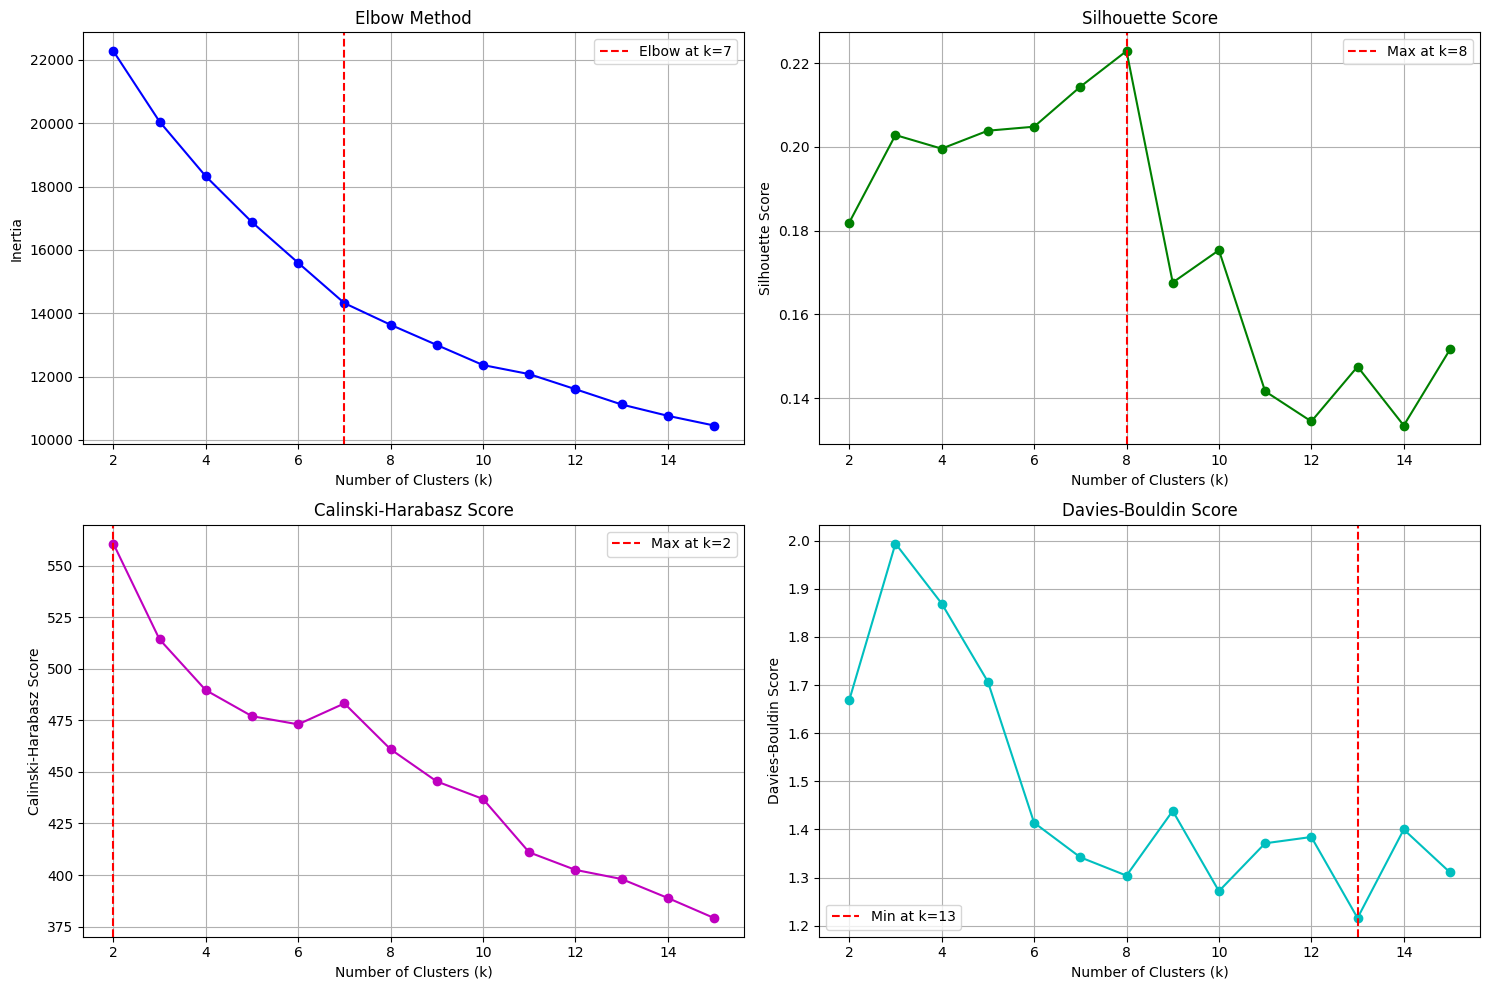


Step 5: Performing K-means clustering with k=8...

Final clustering results with k=8:
Silhouette Score: 0.223
Calinski-Harabasz Score: 461.0
Davies-Bouldin Score: 1.304

Cluster distribution:
Cluster 0: 253 households (6.9%)
Cluster 1: 696 households (19.0%)
Cluster 2: 494 households (13.5%)
Cluster 3: 122 households (3.3%)
Cluster 4: 189 households (5.2%)
Cluster 5: 1 households (0.0%)
Cluster 6: 186 households (5.1%)
Cluster 7: 1714 households (46.9%)

Step 6: Clustering completed successfully!


In [11]:
# K-Means Clustering Pipeline with Preprocessing and Outlier Detection

def prepare_data_for_clustering(df):
    """Prepare data for clustering by identifying categorical and numerical columns"""
    # Reset index to make household_ID a column
    df_reset = df.reset_index()
    
    # Identify categorical and numerical columns
    categorical_cols = []
    numerical_cols = []
    
    for col in df_reset.columns:
        if col == 'household_ID':
            continue
        elif col.endswith('_hours'):
            numerical_cols.append(col)
        else:
            categorical_cols.append(col)
    
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    
    return df_reset, categorical_cols, numerical_cols

def preprocess_data(df, categorical_cols, numerical_cols):
    """Apply one-hot encoding to categorical and standard scaling to numerical columns"""
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        ]
    )
    
    # Fit and transform the data
    X_processed = preprocessor.fit_transform(df[categorical_cols + numerical_cols])
    
    # Get feature names for the processed data
    feature_names = []
    
    # Add numerical feature names
    feature_names.extend(numerical_cols)
    
    # Add categorical feature names (one-hot encoded)
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names.extend(cat_feature_names)
    
    # Create DataFrame with processed features
    X_df = pd.DataFrame(X_processed, columns=feature_names, index=df.index)
    
    return X_df, preprocessor

def remove_outliers_isolation_forest(X_df, household_ids, contamination=0.2):
    """Remove outliers using Isolation Forest"""
    
    # Apply Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
    outlier_labels = iso_forest.fit_predict(X_df)
    
    # Identify inliers (1) and outliers (-1)
    inlier_mask = outlier_labels == 1
    
    print(f"Total samples: {len(X_df)}")
    print(f"Outliers detected: {sum(outlier_labels == -1)}")
    print(f"Inliers kept: {sum(inlier_mask)}")
    
    # Filter data to keep only inliers
    X_clean = X_df[inlier_mask]
    household_ids_clean = household_ids[inlier_mask]
    
    return X_clean, household_ids_clean, outlier_labels

def find_optimal_clusters(X, max_clusters=15):
    """Find optimal number of clusters using multiple methods"""
    
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    
    K_range = range(2, min(max_clusters + 1, len(X)))
    
    print("Calculating clustering metrics for different k values...")
    
    for k in K_range:
        # Fit K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        
        # Calculate metrics
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(X, cluster_labels))
        davies_bouldin_scores.append(davies_bouldin_score(X, cluster_labels))
        
        print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, Calinski-Harasz={calinski_scores[-1]:.1f}, Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")
    
    # Find optimal k using elbow method
    try:
        kl = KneeLocator(K_range, inertias, curve="convex", direction="decreasing")
        elbow_k = kl.elbow
    except:
        elbow_k = None
    
    # Find optimal k using silhouette score (maximum)
    silhouette_k = K_range[np.argmax(silhouette_scores)]
    
    # Find optimal k using Calinski-Harabasz score (maximum)
    calinski_k = K_range[np.argmax(calinski_scores)]
    
    # Find optimal k using Davies-Bouldin score (minimum)
    davies_bouldin_k = K_range[np.argmin(davies_bouldin_scores)]
    
    print(f"\nOptimal k suggestions:")
    if elbow_k:
        print(f"Elbow method: k = {elbow_k}")
    print(f"Silhouette score: k = {silhouette_k} (score: {max(silhouette_scores):.3f})")
    print(f"Calinski-Harabasz: k = {calinski_k} (score: {max(calinski_scores):.1f})")
    print(f"Davies-Bouldin: k = {davies_bouldin_k} (score: {min(davies_bouldin_scores):.3f})")
    
    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Elbow curve
    axes[0, 0].plot(K_range, inertias, 'bo-')
    axes[0, 0].set_xlabel('Number of Clusters (k)')
    axes[0, 0].set_ylabel('Inertia')
    axes[0, 0].set_title('Elbow Method')
    if elbow_k:
        axes[0, 0].axvline(x=elbow_k, color='red', linestyle='--', label=f'Elbow at k={elbow_k}')
        axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Silhouette score
    axes[0, 1].plot(K_range, silhouette_scores, 'go-')
    axes[0, 1].set_xlabel('Number of Clusters (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Score')
    axes[0, 1].axvline(x=silhouette_k, color='red', linestyle='--', label=f'Max at k={silhouette_k}')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Calinski-Harabasz score
    axes[1, 0].plot(K_range, calinski_scores, 'mo-')
    axes[1, 0].set_xlabel('Number of Clusters (k)')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    axes[1, 0].set_title('Calinski-Harabasz Score')
    axes[1, 0].axvline(x=calinski_k, color='red', linestyle='--', label=f'Max at k={calinski_k}')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Davies-Bouldin score
    axes[1, 1].plot(K_range, davies_bouldin_scores, 'co-')
    axes[1, 1].set_xlabel('Number of Clusters (k)')
    axes[1, 1].set_ylabel('Davies-Bouldin Score')
    axes[1, 1].set_title('Davies-Bouldin Score')
    axes[1, 1].axvline(x=davies_bouldin_k, color='red', linestyle='--', label=f'Min at k={davies_bouldin_k}')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return the most commonly suggested k or silhouette-based k
    suggestions = [s for s in [elbow_k, silhouette_k, calinski_k, davies_bouldin_k] if s is not None]
    if suggestions:
        # Use silhouette score as primary criterion
        recommended_k = silhouette_k
    else:
        recommended_k = 3  # Default fallback
    
    return recommended_k, {
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores,
        'davies_bouldin_scores': davies_bouldin_scores,
        'K_range': K_range,
        'elbow_k': elbow_k,
        'silhouette_k': silhouette_k,
        'calinski_k': calinski_k,
        'davies_bouldin_k': davies_bouldin_k
    }

def perform_kmeans_clustering(X, k, household_ids):
    """Perform final K-means clustering and return results"""
    
    # Fit K-means with optimal k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'household_ID': household_ids,
        'cluster': cluster_labels
    })
    
    # Calculate final metrics
    silhouette_avg = silhouette_score(X, cluster_labels)
    calinski_avg = calinski_harabasz_score(X, cluster_labels)
    davies_bouldin_avg = davies_bouldin_score(X, cluster_labels)
    
    print(f"\nFinal clustering results with k={k}:")
    print(f"Silhouette Score: {silhouette_avg:.3f}")
    print(f"Calinski-Harabasz Score: {calinski_avg:.1f}")
    print(f"Davies-Bouldin Score: {davies_bouldin_avg:.3f}")
    
    # Show cluster distribution
    cluster_counts = results_df['cluster'].value_counts().sort_index()
    print(f"\nCluster distribution:")
    for cluster_id, count in cluster_counts.items():
        print(f"Cluster {cluster_id}: {count} households ({count/len(results_df)*100:.1f}%)")
    
    return results_df, kmeans

# Execute the complete clustering pipeline
print("=== K-MEANS CLUSTERING PIPELINE ===")
print("\nStep 1: Preparing data for clustering...")

# Prepare data
data_for_clustering, categorical_cols, numerical_cols = prepare_data_for_clustering(appliance_features)

print("\nStep 2: Preprocessing data (One-hot encoding + Standard scaling)...")

# Preprocess data
X_processed, preprocessor = preprocess_data(data_for_clustering, categorical_cols, numerical_cols)
print(f"Processed feature matrix shape: {X_processed.shape}")

print("\nStep 3: Removing outliers using Isolation Forest...")

# Remove outliers
X_clean, household_ids_clean, outlier_labels = remove_outliers_isolation_forest(
    X_processed, 
    data_for_clustering['household_ID'].values, 
    contamination=0.1
)

print("\nStep 4: Finding optimal number of clusters...")

# Find optimal clusters
optimal_k, metrics = find_optimal_clusters(X_clean, max_clusters=15)

print(f"\nStep 5: Performing K-means clustering with k={optimal_k}...")

# Perform final clustering
clustering_results, kmeans_model = perform_kmeans_clustering(X_clean, optimal_k, household_ids_clean)

print("\nStep 6: Clustering completed successfully!")

In [12]:
def merge_small_clusters(X, clustering_results, kmeans_model, min_cluster_size=2):
    """Merge clusters with very few members into their nearest clusters"""
    
    results_df = clustering_results.copy()
    cluster_centers = kmeans_model.cluster_centers_
    
    # Find clusters with less than min_cluster_size members
    cluster_counts = results_df['cluster'].value_counts()
    small_clusters = cluster_counts[cluster_counts < min_cluster_size].index.tolist()
    
    if not small_clusters:
        print(f"No clusters with less than {min_cluster_size} members found.")
        return results_df
    
    print(f"\nFound {len(small_clusters)} small cluster(s): {small_clusters}")
    
    for small_cluster in small_clusters:
        # Get the center of the small cluster
        small_cluster_center = cluster_centers[small_cluster]
        
        # Find distances to all other cluster centers
        distances = []
        other_clusters = [c for c in range(len(cluster_centers)) if c != small_cluster and c not in small_clusters]
        
        for other_cluster in other_clusters:
            distance = np.linalg.norm(small_cluster_center - cluster_centers[other_cluster])
            distances.append((other_cluster, distance))
        
        # Find the nearest cluster
        if distances:
            nearest_cluster, min_distance = min(distances, key=lambda x: x[1])
            
            # Get households in the small cluster
            households_to_move = results_df[results_df['cluster'] == small_cluster]['household_ID'].tolist()
            
            print(f"Merging cluster {small_cluster} ({len(households_to_move)} household(s)) into cluster {nearest_cluster}")
            print(f"  - Households moved: {households_to_move}")
            print(f"  - Distance between cluster centers: {min_distance:.3f}")
            
            # Reassign households
            results_df.loc[results_df['cluster'] == small_cluster, 'cluster'] = nearest_cluster
    
    # Update cluster labels to be consecutive (0, 1, 2, ...)
    unique_clusters = sorted(results_df['cluster'].unique())
    cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(unique_clusters)}
    results_df['cluster'] = results_df['cluster'].map(cluster_mapping)
    
    print(f"\nFinal cluster mapping: {cluster_mapping}")
    
    # Show updated cluster distribution
    updated_cluster_counts = results_df['cluster'].value_counts().sort_index()
    print(f"\nUpdated cluster distribution:")
    for cluster_id, count in updated_cluster_counts.items():
        print(f"Cluster {cluster_id}: {count} households ({count/len(results_df)*100:.1f}%)")
    
    return results_df

# Apply the small cluster merging
print("\n=== MERGING SMALL CLUSTERS ===")
final_clustering_results = merge_small_clusters(X_clean, clustering_results, kmeans_model, min_cluster_size=2)

print("\n=== FINAL CLUSTERING SUMMARY ===")
print(f"Total households clustered: {len(final_clustering_results)}")
print(f"Number of final clusters: {final_clustering_results['cluster'].nunique()}")

# Display sample of final results
print("\nSample of final clustering results:")
print(final_clustering_results.head(10))

# Save results to CSV
output_file = '/home/ranushi/test/Anomaly DetectionMethod/SL_electricity_consumption/New Autoencoder Codes/household_clusters_final.csv'
final_clustering_results.to_csv(output_file, index=False)
print(f"\nResults saved to: {output_file}")


=== MERGING SMALL CLUSTERS ===

Found 1 small cluster(s): [5]
Merging cluster 5 (1 household(s)) into cluster 7
  - Households moved: ['ID3155']
  - Distance between cluster centers: 35.850

Final cluster mapping: {np.int32(0): 0, np.int32(1): 1, np.int32(2): 2, np.int32(3): 3, np.int32(4): 4, np.int32(6): 5, np.int32(7): 6}

Updated cluster distribution:
Cluster 0: 253 households (6.9%)
Cluster 1: 696 households (19.0%)
Cluster 2: 494 households (13.5%)
Cluster 3: 122 households (3.3%)
Cluster 4: 189 households (5.2%)
Cluster 5: 186 households (5.1%)
Cluster 6: 1715 households (46.9%)

=== FINAL CLUSTERING SUMMARY ===
Total households clustered: 3655
Number of final clusters: 7

Sample of final clustering results:
  household_ID  cluster
0       ID0001        6
1       ID0002        6
2       ID0003        0
3       ID0004        2
4       ID0005        0
5       ID0006        2
6       ID0007        6
7       ID0008        0
8       ID0009        1
9       ID0010        3

Results s

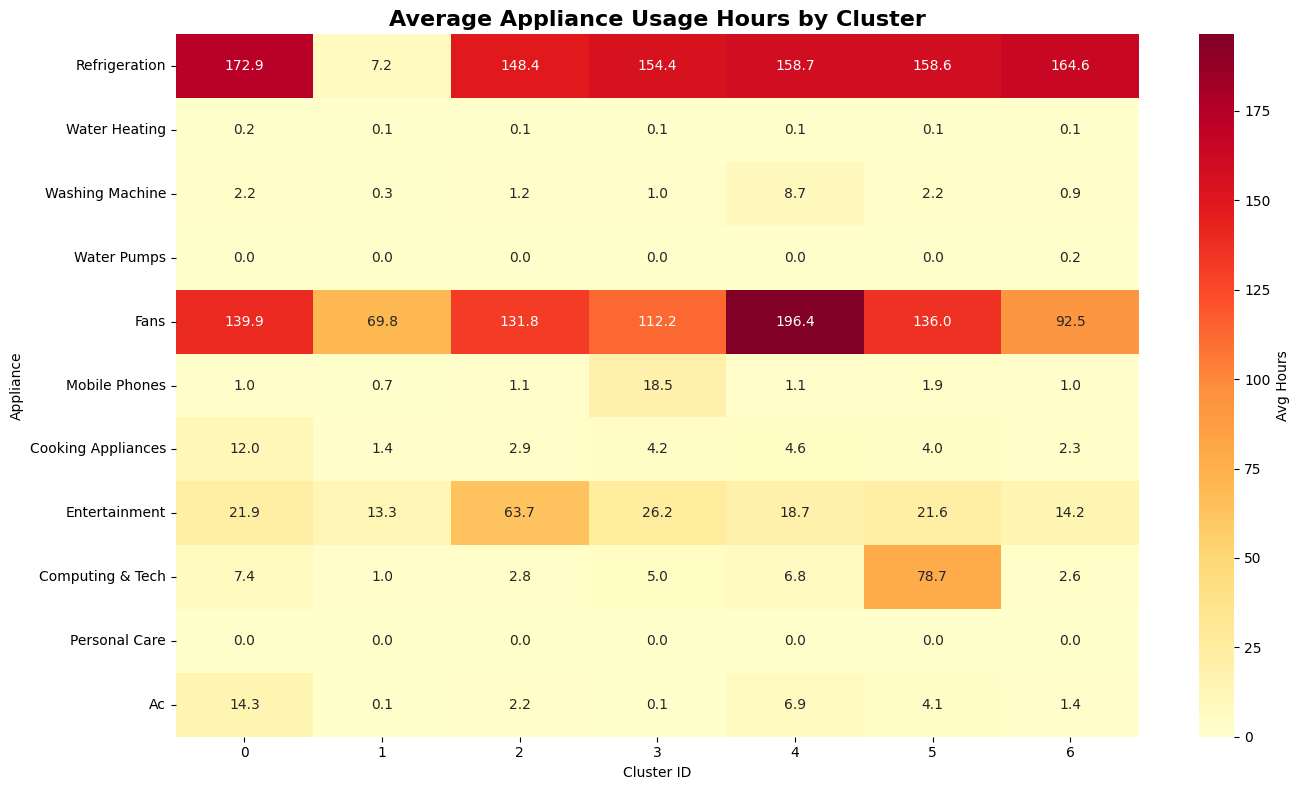

In [13]:
# Merge clustering results with original features
clustered_data = appliance_features.merge(final_clustering_results, on="household_ID")

# Get only usage hour columns
appliance_hours_cols = [col for col in clustered_data.columns if col.endswith('_hours')]

# Average usage by cluster
appliance_usage_by_cluster = clustered_data.groupby('cluster')[appliance_hours_cols].mean()

# Clean names for plotting
appliance_display_names = [col.replace("_hours", "").replace("_", " ").title() for col in appliance_hours_cols]
appliance_usage_display = appliance_usage_by_cluster.copy()
appliance_usage_display.columns = appliance_display_names

# Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(appliance_usage_display.T, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Avg Hours'})
plt.title("Average Appliance Usage Hours by Cluster", fontsize=16, fontweight="bold")
plt.xlabel("Cluster ID")
plt.ylabel("Appliance")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


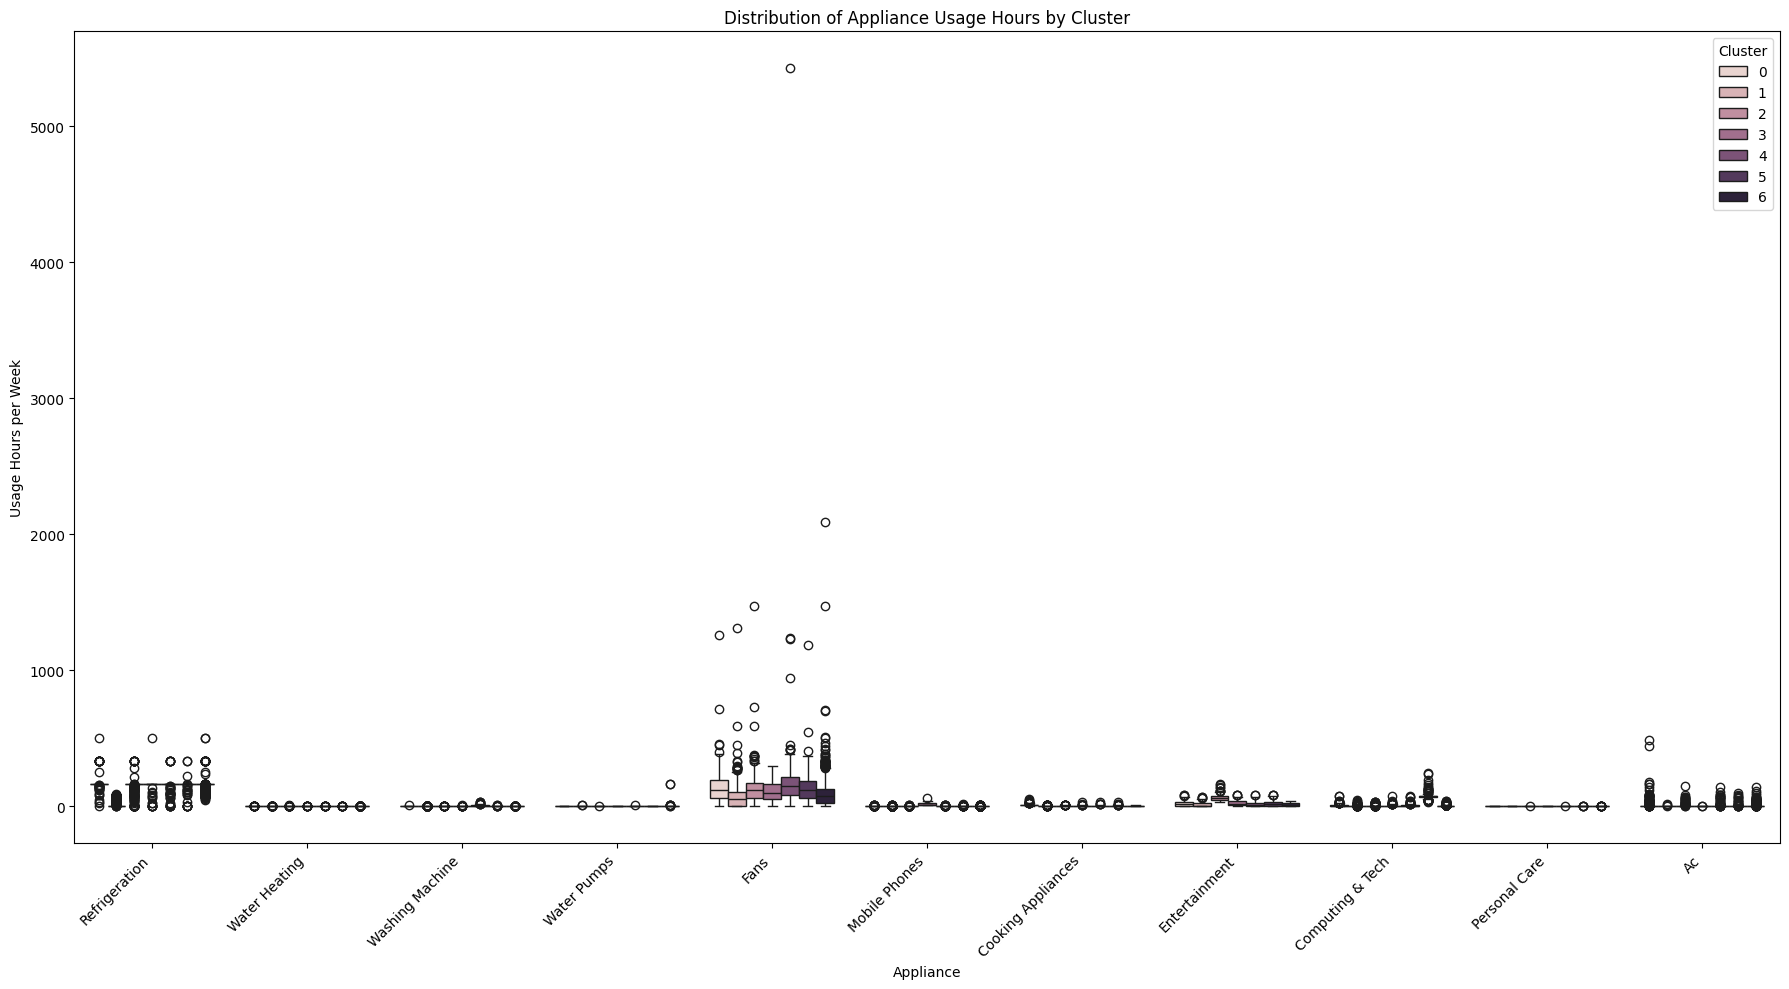

In [14]:
# Melt dataframe for plotting
melted = clustered_data.melt(id_vars=['household_ID', 'cluster'], 
                             value_vars=appliance_hours_cols, 
                             var_name="Appliance", value_name="Hours")

# Clean names
melted["Appliance"] = melted["Appliance"].str.replace("_hours", "").str.replace("_", " ").str.title()

plt.figure(figsize=(18, 10))
sns.boxplot(data=melted, x="Appliance", y="Hours", hue="cluster")
plt.title("Distribution of Appliance Usage Hours by Cluster")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Usage Hours per Week")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [15]:
intra_cluster_variance = clustered_data.groupby("cluster")[appliance_hours_cols].var().mean(axis=1)
print("\nAverage variance of appliance usage within each cluster:")
print(intra_cluster_variance.round(2))



Average variance of appliance usage within each cluster:
cluster
0     1847.53
1      725.40
2     1372.01
3      886.27
4    15829.13
5     1582.98
6     1007.25
dtype: float64


In [16]:
survey_data = pd.read_csv(HOUSEHOLD_INFO_FILE)

In [17]:
survey_data.columns

Index(['household_ID', 'no_of_electricity_meters',
       'electricity_provider_csc_area', 'own_the_house_or_living_on_rent',
       'occupy_renters_boarders',
       'awareness_of_electricity_consumption_of_renters',
       'built_year_of_the_house', 'type_of_house', 'floor_which_house_located',
       'no_of_storeys', 'floor_area', 'no_of_household_members',
       'charging_method_of_renters_for_electricity',
       'charged_method_for_rent_for_electricity',
       'is_there_business_carried_out_in_the_household', 'type_of_business',
       'whom_or_how_the_house_was_designed',
       'availability_of_certificate_of_compliance',
       'main_material_used_for_walls_of_the_house',
       'main_material_used_for_roof_of_the_house',
       'any_constructions_or_renovations_in_the_household',
       'highest_level_of_education_of_the_chief_wage_earner',
       'occupation_of_the_chief_wage_earner', 'socio_economic_class',
       'total_monthly_expenditure_of_last_month', 'type_of_electr

In [18]:
# Merge household size info into your clustered data
clustered_with_size = clustered_data.merge(
    survey_data[['household_ID', 'no_of_household_members']],
    on='household_ID',
    how='inner'
)

# Avoid division by zero (just in case)
clustered_with_size['no_of_household_members'] = clustered_with_size['no_of_household_members'].replace(0, np.nan)

# Compute per-person usage for all appliance hour columns
appliance_hours_cols = [col for col in clustered_data.columns if col.endswith('_hours')]
for col in appliance_hours_cols:
    clustered_with_size[col + "_per_person"] = clustered_with_size[col] / clustered_with_size['no_of_household_members']

# Now calculate intra-cluster variance using per-person usage
per_person_cols = [col + "_per_person" for col in appliance_hours_cols]
intra_cluster_variance_per_person = (
    clustered_with_size.groupby("cluster")[per_person_cols].var().mean(axis=1)
)

print("\nAverage variance of per-person appliance usage within each cluster:")
print(intra_cluster_variance_per_person.round(2))



Average variance of per-person appliance usage within each cluster:
cluster
0    178.05
1     68.31
2    152.18
3    126.96
4    294.75
5    160.86
6    167.36
dtype: float64


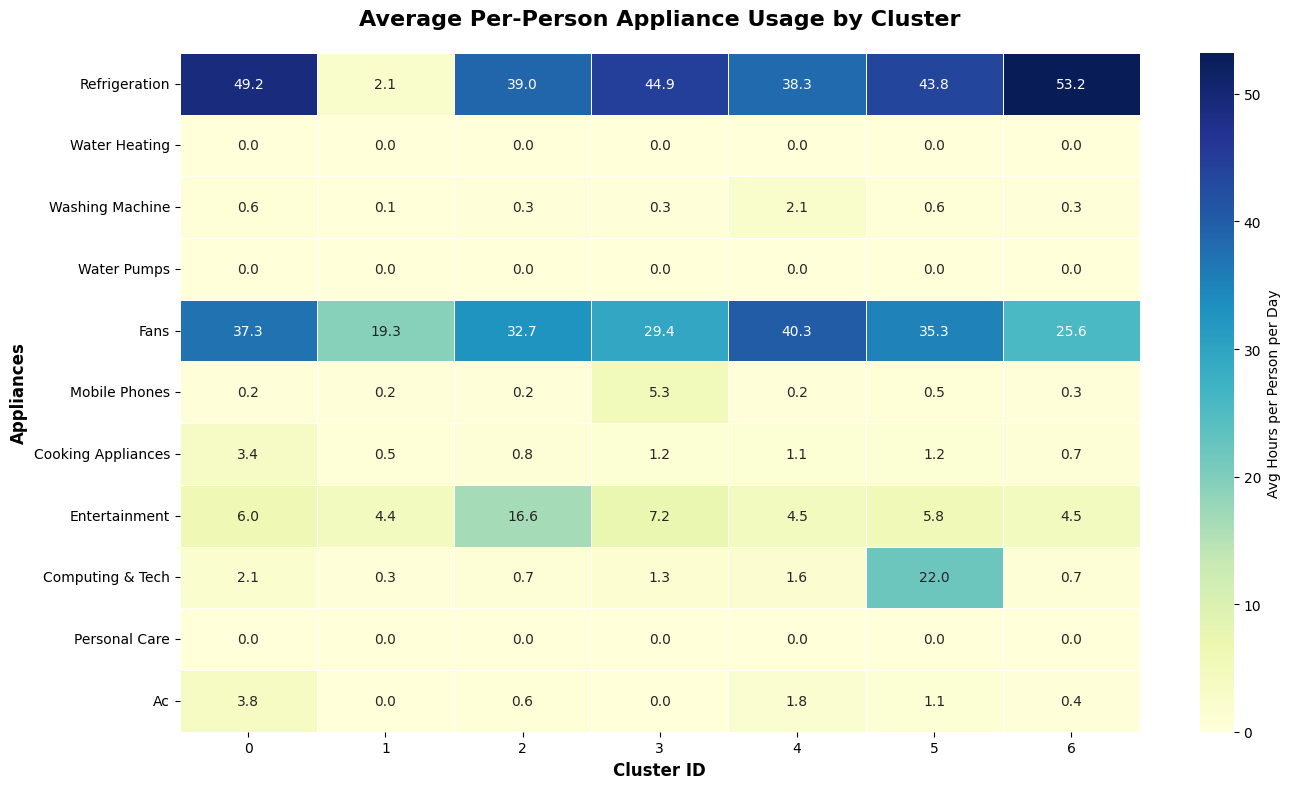

In [19]:
# -------------------------------
# Heatmap of per-person appliance usage by cluster
# -------------------------------

# Merge household member count into clustered data
clustered_with_survey = clustered_data.merge(
    survey_data[['household_ID', 'no_of_household_members']],
    on='household_ID',
    how='left'
)

# Compute per-person usage
for col in appliance_hours_cols:
    clustered_with_survey[f"{col}_per_person"] = (
        clustered_with_survey[col] / clustered_with_survey['no_of_household_members'].clip(lower=1)
    )

# Group by cluster and average per-person usage
per_person_usage_by_cluster = clustered_with_survey.groupby("cluster")[
    [f"{col}_per_person" for col in appliance_hours_cols]
].mean()

# Clean display names
appliance_display_names = [col.replace('_hours_per_person', '').replace('_hours', '').replace('_', ' ').title() 
                           for col in per_person_usage_by_cluster.columns]
per_person_usage_display = per_person_usage_by_cluster.copy()
per_person_usage_display.columns = appliance_display_names

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(per_person_usage_display.T, 
            annot=True, 
            fmt='.1f', 
            cmap='YlGnBu',
            cbar_kws={'label': 'Avg Hours per Person per Day'},
            linewidths=0.5)

plt.title('Average Per-Person Appliance Usage by Cluster', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster ID', fontsize=12, fontweight='bold')
plt.ylabel('Appliances', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [20]:
# Import required libraries for autoencoder anomaly detection
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully for autoencoder anomaly detection")

2025-10-02 09:17:14.917149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759376834.929534 1971865 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759376834.933725 1971865 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759376834.944427 1971865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759376834.944441 1971865 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759376834.944442 1971865 computation_placer.cc:177] computation placer alr

Libraries imported successfully for autoencoder anomaly detection


In [21]:
# Configuration parameters for autoencoder anomaly detection
print("=" * 70)
print("AUTOENCODER ANOMALY DETECTION CONFIGURATION")
print("=" * 70)

# Data paths and parameters
DATA_DIR = Path('/home/ranushi/test/Anomaly DetectionMethod/6hour_interval')
DATE_COL = 'DATE'
TIME_COL = 'TIME'
KWH_COL = 'TOTAL_IMPORT (kWh)'
HH_ID_COL_CANDIDATES = ['household_ID', 'household_id', 'hhid', 'HHID']

# Autoencoder parameters
SEQUENCE_LENGTH = 30  # 30 * 6h = 180h (~7.5 days) window
EPOCHS = 40
BATCH_SIZE = 32
SEQ_ANOMALY_PCT = 80  # Top 20% sequences as anomalous
HH_ANOMALY_PCT = 80   # Top 20% households among anomalous sequences
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)

print(f"Data directory: {DATA_DIR}")
print(f"Sequence length: {SEQUENCE_LENGTH} (6-hour intervals)")
print(f"Training epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Sequence anomaly percentile: {SEQ_ANOMALY_PCT}")
print(f"Household anomaly percentile: {HH_ANOMALY_PCT}")

AUTOENCODER ANOMALY DETECTION CONFIGURATION
Data directory: /home/ranushi/test/Anomaly DetectionMethod/6hour_interval
Sequence length: 30 (6-hour intervals)
Training epochs: 40
Batch size: 32
Sequence anomaly percentile: 80
Household anomaly percentile: 80


In [22]:
# Helper functions for autoencoder anomaly detection
def pick_first_present(df, candidates):
    """Find the first column name that exists in the dataframe"""
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f'None of the candidate columns {candidates} found in dataframe columns: {df.columns.tolist()}')

def build_sequences(array_2d: np.ndarray, seq_len: int) -> np.ndarray:
    """
    Convert a 2D time-series array into overlapping sequences.
    
    Parameters:
    -----------
    array_2d : np.ndarray
        Shape (timesteps, n_features). Each column = household, each row = time step.
    seq_len : int
        Sequence length (number of timesteps per sequence).
    
    Returns:
    --------
    np.ndarray
        Shape (num_sequences, seq_len, n_features).
    """
    sequences = []
    for i in range(len(array_2d) - seq_len + 1):
        sequences.append(array_2d[i:i + seq_len])
    return np.array(sequences)

def build_autoencoder(n_features: int, seq_len: int, latent_units: int = 128) -> Model:
    """
    Build an LSTM autoencoder for sequence reconstruction.
    
    Parameters:
    -----------
    n_features : int
        Number of features (households).
    seq_len : int
        Sequence length.
    latent_units : int
        Number of LSTM units in encoder/decoder.
    
    Returns:
    --------
    keras.Model
        Compiled LSTM autoencoder.
    """
    inp = Input(shape=(seq_len, n_features))
    encoded = LSTM(latent_units, activation='relu', return_sequences=False)(inp)
    decoded = RepeatVector(seq_len)(encoded)
    decoded = LSTM(latent_units, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)
    
    model = Model(inp, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies(sequences: np.ndarray, model: Model, seq_pct: float, hh_pct: float, random_state: int = 42):
    """
    Train autoencoder, compute reconstruction errors, and detect anomalous sequences/households.
    
    Parameters:
    -----------
    sequences : np.ndarray
        Input sequences of shape (num_sequences, seq_len, n_features).
    model : keras.Model
        Autoencoder model.
    seq_pct : float
        Percentile threshold for anomalous sequences (e.g., 80 = top 20%).
    hh_pct : float
        Percentile threshold for anomalous households among anomalous sequences.
    random_state : int
        Random seed for reproducibility.
    
    Returns:
    --------
    dict
        Dictionary containing anomaly detection results.
    """
    # Train/validation split
    X_train, X_val = train_test_split(sequences, test_size=0.2, random_state=random_state)
    
    # Train the autoencoder
    history = model.fit(
        X_train, X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, X_val),
        verbose=0
    )
    
    # Reconstruction
    reconstructed = model.predict(sequences, verbose=0)
    
    # Sequence-level errors
    seq_errors = np.mean(np.square(sequences - reconstructed), axis=(1, 2))
    seq_threshold = np.percentile(seq_errors, seq_pct)
    seq_anom_mask = seq_errors > seq_threshold
    
    # Household-level errors (among anomalous sequences only)
    anomalous_sequences = sequences[seq_anom_mask]
    anomalous_recon = reconstructed[seq_anom_mask]
    per_hh_errors = np.square(anomalous_sequences - anomalous_recon)  # (num_anom_seq, seq_len, n_features)
    hh_errors = per_hh_errors.mean(axis=(0, 1))  # average over sequences + timesteps
    hh_threshold = np.percentile(hh_errors, hh_pct)
    hh_anom_idx = np.where(hh_errors > hh_threshold)[0]
    
    return {
        'history': history,
        'sequence_errors': seq_errors,
        'sequence_threshold': seq_threshold,
        'sequence_anomaly_mask': seq_anom_mask,
        'household_errors': hh_errors,
        'household_threshold': hh_threshold,
        'household_anom_indices': hh_anom_idx
    }

print("Helper functions defined successfully")

Helper functions defined successfully


In [24]:
DATA_DIR

PosixPath('/home/ranushi/test/Anomaly DetectionMethod/6hour_interval')

In [25]:
# Load 6-hour interval energy consumption data
print("=" * 70)
print("LOADING 6-HOUR INTERVAL ENERGY CONSUMPTION DATA")
print("=" * 70)

# Check if data directory exists
if not DATA_DIR.exists():
    print(f"ERROR: Data directory {DATA_DIR} does not exist!")
    print("Please ensure the 6hour_interval folder exists with CSV files")
    all_6hour_data = pd.DataFrame()
else:
    # Load all CSV files from 6hour_interval directory
    all_data = []
    csv_files = list(DATA_DIR.glob('*.csv'))
    
    print(f"Found {len(csv_files)} CSV files in {DATA_DIR}")
    
    for csv_path in csv_files:
        try:
            print(f"Loading {csv_path.name}...")
            df = pd.read_csv(csv_path, low_memory=False)
            all_data.append(df)
            print(f"  Loaded {df.shape[0]} rows, {df.shape[1]} columns")
        except Exception as e:
            print(f"  Error loading {csv_path.name}: {e}")
            continue
    
    if not all_data:
        print("ERROR: No 6-hour interval CSV files could be loaded.")
        all_6hour_data = pd.DataFrame()
    else:
        # Concatenate all data
        print(f"\nConcatenating {len(all_data)} dataframes...")
        all_6hour_data = pd.concat(all_data, ignore_index=True)
        print(f"Combined data shape: {all_6hour_data.shape}")
        
        # Display sample of columns
        print(f"\nColumns in 6-hour data: {all_6hour_data.columns.tolist()[:10]}{'...' if len(all_6hour_data.columns) > 10 else ''}")

LOADING 6-HOUR INTERVAL ENERGY CONSUMPTION DATA
Found 5 CSV files in /home/ranushi/test/Anomaly DetectionMethod/6hour_interval
Loading smart_6hour_1.csv...
  Loaded 1115230 rows, 32 columns
Loading smart_6hour_4.csv...
  Loaded 680674 rows, 32 columns
Loading smart_6hour_3.csv...
  Loaded 1047075 rows, 32 columns
Loading smart_6hour_2.csv...
  Loaded 1319347 rows, 32 columns
Loading smart_6hour_5.csv...
  Loaded 279467 rows, 32 columns

Concatenating 5 dataframes...
Combined data shape: (4441793, 32)

Columns in 6-hour data: ['household_ID', 'BRANCH', 'DEPOT', 'substation_ID', 'SUB_TYPE', 'E_BILLING', 'EXPORT', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)']...


In [26]:
# Process and clean 6-hour interval data
if not all_6hour_data.empty:
    print("\n=== PROCESSING 6-HOUR INTERVAL DATA ===")
    
    # Find household ID column
    try:
        hh_id_col = pick_first_present(all_6hour_data, HH_ID_COL_CANDIDATES)
        print(f"Found household ID column: {hh_id_col}")
    except KeyError as e:
        print(f"ERROR: {e}")
        print(f"Available columns: {all_6hour_data.columns.tolist()}")
        all_6hour_data = pd.DataFrame()
    
    if not all_6hour_data.empty:
        # Check required columns
        cols_needed = [hh_id_col, DATE_COL, TIME_COL, KWH_COL]
        missing = [c for c in cols_needed if c not in all_6hour_data.columns]
        
        if missing:
            print(f"ERROR: Missing required columns in smart meter data: {missing}")
            print(f"Available columns: {all_6hour_data.columns.tolist()}")
            all_6hour_data = pd.DataFrame()
        else:
            print(f"All required columns found: {cols_needed}")
            
            # Keep only needed columns
            raw_df = all_6hour_data[cols_needed].copy()
            print(f"Filtered data shape: {raw_df.shape}")
            
            # Process datetime
            print("\nProcessing datetime columns...")
            raw_df[TIME_COL] = raw_df[TIME_COL].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')
            raw_df['DATETIME'] = pd.to_datetime(raw_df[DATE_COL] + ' ' + raw_df[TIME_COL], errors='coerce')
            
            # Convert consumption to numeric and remove NaN
            raw_df[KWH_COL] = pd.to_numeric(raw_df[KWH_COL], errors='coerce')
            initial_rows = len(raw_df)
            raw_df = raw_df.dropna(subset=['DATETIME', KWH_COL])
            print(f"Removed {initial_rows - len(raw_df)} rows with invalid datetime/consumption")
            
            # Sort by household and datetime
            raw_df = raw_df.sort_values([hh_id_col, 'DATETIME'])
            
            # Convert cumulative import to interval consumption (diff per 6h)
            print("Converting cumulative consumption to interval consumption...")
            raw_df[KWH_COL] = raw_df.groupby(hh_id_col)[KWH_COL].diff()
            
            # Remove first diff (NaN) and negative values
            initial_rows = len(raw_df)
            raw_df = raw_df.dropna(subset=[KWH_COL])
            raw_df = raw_df[raw_df[KWH_COL] >= 0]  # Remove negative consumption
            print(f"Removed {initial_rows - len(raw_df)} rows after diff calculation and negative filtering")
            
            # Floor to 6h and deduplicate
            raw_df['DATETIME'] = raw_df['DATETIME'].dt.floor('6h')
            initial_rows = len(raw_df)
            raw_df = raw_df.drop_duplicates(subset=[hh_id_col, 'DATETIME'])
            print(f"Removed {initial_rows - len(raw_df)} duplicate records after 6h floor")
            
            print(f"\nFinal processed data shape: {raw_df.shape}")
            print(f"Unique households: {raw_df[hh_id_col].nunique()}")
            print(f"Date range: {raw_df['DATETIME'].min()} to {raw_df['DATETIME'].max()}")
            
else:
    print("No 6-hour data available for processing")
    raw_df = pd.DataFrame()


=== PROCESSING 6-HOUR INTERVAL DATA ===
Found household ID column: household_ID
All required columns found: ['household_ID', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)']
Filtered data shape: (4441793, 4)

Processing datetime columns...
Removed 15 rows with invalid datetime/consumption
Converting cumulative consumption to interval consumption...
Removed 22368 rows after diff calculation and negative filtering
Removed 1176863 duplicate records after 6h floor

Final processed data shape: (3242547, 5)
Unique households: 2950
Date range: 2023-01-01 00:00:00 to 2024-12-31 18:00:00


In [ ]:
# # Process and clean 6-hour interval data
# if not all_6hour_data.empty:
#     print("\n=== PROCESSING 6-HOUR INTERVAL DATA ===")
    
#     # Find household ID column
#     try:
#         hh_id_col = pick_first_present(all_6hour_data, HH_ID_COL_CANDIDATES)
#         print(f"Found household ID column: {hh_id_col}")
#     except KeyError as e:
#         print(f"ERROR: {e}")
#         print(f"Available columns: {all_6hour_data.columns.tolist()}")
#         all_6hour_data = pd.DataFrame()
    
#     if not all_6hour_data.empty:
#         # Check required columns
#         cols_needed = [hh_id_col, DATE_COL, TIME_COL, KWH_COL]
#         missing = [c for c in cols_needed if c not in all_6hour_data.columns]
        
#         if missing:
#             print(f"ERROR: Missing required columns in smart meter data: {missing}")
#             print(f"Available columns: {all_6hour_data.columns.tolist()}")
#             all_6hour_data = pd.DataFrame()
#         else:
#             print(f"All required columns found: {cols_needed}")
            
#             # Keep only needed columns
#             raw_df = all_6hour_data[cols_needed].copy()
#             print(f"Filtered data shape: {raw_df.shape}")
            
#             # Process datetime
#             print("\nProcessing datetime columns...")
#             raw_df[TIME_COL] = raw_df[TIME_COL].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')
#             raw_df['DATETIME'] = pd.to_datetime(raw_df[DATE_COL] + ' ' + raw_df[TIME_COL], errors='coerce')
            
#             # Convert consumption to numeric and remove NaN
#             raw_df[KWH_COL] = pd.to_numeric(raw_df[KWH_COL], errors='coerce')
#             initial_rows = len(raw_df)
#             raw_df = raw_df.dropna(subset=['DATETIME', KWH_COL])
#             print(f"Removed {initial_rows - len(raw_df)} rows with invalid datetime/consumption")
            
#             # Sort by household and datetime
#             raw_df = raw_df.sort_values([hh_id_col, 'DATETIME'])
            
#             # Convert cumulative import to interval consumption (diff per 6h)
#             print("Converting cumulative consumption to interval consumption...")
#             raw_df[KWH_COL] = raw_df.groupby(hh_id_col)[KWH_COL].diff()
            
#             # Remove first diff (NaN) and negative values
#             initial_rows = len(raw_df)
#             raw_df = raw_df.dropna(subset=[KWH_COL])
#             raw_df = raw_df[raw_df[KWH_COL] >= 0]  # Remove negative consumption
#             print(f"Removed {initial_rows - len(raw_df)} rows after diff calculation and negative filtering")
            
#             # Floor to 6h and deduplicate
#             raw_df['DATETIME'] = raw_df['DATETIME'].dt.floor('6h')
#             initial_rows = len(raw_df)
#             raw_df = raw_df.drop_duplicates(subset=[hh_id_col, 'DATETIME'])
#             print(f"Removed {initial_rows - len(raw_df)} duplicate records after 6h floor")
            
#             print(f"\nFinal processed data shape: {raw_df.shape}")
#             print(f"Unique households: {raw_df[hh_id_col].nunique()}")
#             print(f"Date range: {raw_df['DATETIME'].min()} to {raw_df['DATETIME'].max()}")
            
# else:
#     print("No 6-hour data available for processing")
#     raw_df = pd.DataFrame()


=== PROCESSING 6-HOUR INTERVAL DATA ===
Found household ID column: household_ID
All required columns found: ['household_ID', 'DATE', 'TIME', 'TOTAL_IMPORT (kWh)']
Filtered data shape: (4441793, 4)

Processing datetime columns...
Removed 15 rows with invalid datetime/consumption
Converting cumulative consumption to interval consumption...
Removed 22368 rows after diff calculation and negative filtering
Removed 1176863 duplicate records after 6h floor

Final processed data shape: (3242547, 5)
Unique households: 2950
Date range: 2023-01-01 00:00:00 to 2024-12-31 18:00:00


In [27]:
# Create pivot table and filter households
if not raw_df.empty:
    print("\n=== CREATING PIVOT TABLE AND FILTERING DATA ===")
    
    # Pivot to time x household matrix
    print("Creating time x household pivot table...")
    pivot_df = raw_df.pivot(index='DATETIME', columns=hh_id_col, values=KWH_COL)
    pivot_df = pivot_df.sort_index()
    print(f"Pivot table shape: {pivot_df.shape} (time x households)")
    
    # Fill missing values more aggressively
    print("\nFilling missing values with forward/backward fill...")
    initial_nan_count = pivot_df.isnull().sum().sum()
    pivot_df = pivot_df.ffill().bfill()  # forward fill then backfill
    final_nan_count = pivot_df.isnull().sum().sum()
    print(f"Filled {initial_nan_count - final_nan_count} missing values")
    
    # Keep households with at least 40% data coverage
    print("\nFiltering households with sufficient data coverage...")
    min_required = int(0.4 * len(pivot_df))  # 40% of rows must be non-NaN
    initial_households = pivot_df.shape[1]
    pivot_df = pivot_df.dropna(axis=1, thresh=min_required)
    final_households = pivot_df.shape[1]
    print(f"Removed {initial_households - final_households} households with <40% data coverage")
    print(f"Final households after cleaning: {final_households}")
    
    if final_households == 0:
        print("ERROR: No households remaining after data quality filtering!")
        pivot_df = pd.DataFrame()
    
else:
    print("No raw data available for pivot table creation")
    pivot_df = pd.DataFrame()


=== CREATING PIVOT TABLE AND FILTERING DATA ===
Creating time x household pivot table...
Pivot table shape: (2734, 2950) (time x households)

Filling missing values with forward/backward fill...
Filled 4822753 missing values

Filtering households with sufficient data coverage...
Removed 0 households with <40% data coverage
Final households after cleaning: 2950


In [30]:
# Get cluster assignments and filter households
print("\n" + "=" * 70)
print("FILTERING HOUSEHOLDS BY CLUSTER ASSIGNMENTS")
print("=" * 70)

# Check if clustering results are available
if 'final_clustering_results' in locals() and final_clustering_results is not None:
    # Get cluster assignments
    cluster_assignments = final_clustering_results[['cluster']].copy()
    cluster_assignments['household_ID'] = final_clustering_results['household_ID']
    
    print(f"Cluster assignments available for {len(cluster_assignments)} households")
    cluster_counts = cluster_assignments['cluster'].value_counts().sort_index()
    print("\nHouseholds per cluster:")
    for cluster_id, count in cluster_counts.items():
        print(f"  Cluster {cluster_id}: {count} households")
    
    # Find intersection between clustered households and 6-hour data
    if not pivot_df.empty:
        clustered_households = set(cluster_assignments['household_ID'])
        sixhour_households = set(pivot_df.columns)
        common_households = clustered_households.intersection(sixhour_households)
        
        print(f"\nHousehold intersection:")
        print(f"  Clustered households: {len(clustered_households)}")
        print(f"  6-hour data households: {len(sixhour_households)}")
        print(f"  Common households: {len(common_households)}")
        
        if len(common_households) == 0:
            print("ERROR: No common households found between cluster assignments and 6-hour data!")
            print("\nDebugging information:")
            print(f"Sample clustered household IDs: {list(clustered_households)[:5]}")
            print(f"Sample 6-hour data household IDs: {list(sixhour_households)[:5]}")
            cluster_filtered_data = {}
        else:
            # Filter pivot data to common households only
            pivot_df_filtered = pivot_df[list(common_households)].copy()
            
            # Filter cluster assignments to common households only
            cluster_assignments_filtered = cluster_assignments[
                cluster_assignments['household_ID'].isin(common_households)
            ].copy()
            
            print(f"\nFiltered data shape: {pivot_df_filtered.shape}")
            
            # Create cluster-specific datasets
            cluster_filtered_data = {}
            for cluster_id in sorted(cluster_assignments_filtered['cluster'].unique()):
                cluster_households = cluster_assignments_filtered[
                    cluster_assignments_filtered['cluster'] == cluster_id
                ]['household_ID'].tolist()
                
                cluster_data = pivot_df_filtered[cluster_households].copy()
                cluster_filtered_data[cluster_id] = {
                    'data': cluster_data,
                    'households': cluster_households,
                    'count': len(cluster_households)
                }
                
                print(f"  Cluster {cluster_id}: {len(cluster_households)} households, shape {cluster_data.shape}")
    else:
        print("No 6-hour data available for filtering")
        cluster_filtered_data = {}
        
else:
    print("ERROR: No cluster results available!")
    print("Please ensure the clustering analysis has been completed first.")
    cluster_filtered_data = {}


FILTERING HOUSEHOLDS BY CLUSTER ASSIGNMENTS
Cluster assignments available for 3655 households

Households per cluster:
  Cluster 0: 253 households
  Cluster 1: 696 households
  Cluster 2: 494 households
  Cluster 3: 122 households
  Cluster 4: 189 households
  Cluster 5: 186 households
  Cluster 6: 1715 households

Household intersection:
  Clustered households: 3655
  6-hour data households: 2950
  Common households: 1282

Filtered data shape: (2734, 1282)
  Cluster 0: 98 households, shape (2734, 98)
  Cluster 1: 213 households, shape (2734, 213)
  Cluster 2: 172 households, shape (2734, 172)
  Cluster 3: 61 households, shape (2734, 61)
  Cluster 4: 60 households, shape (2734, 60)
  Cluster 5: 88 households, shape (2734, 88)
  Cluster 6: 590 households, shape (2734, 590)


In [32]:
survey_data.columns

Index(['household_ID', 'no_of_electricity_meters',
       'electricity_provider_csc_area', 'own_the_house_or_living_on_rent',
       'occupy_renters_boarders',
       'awareness_of_electricity_consumption_of_renters',
       'built_year_of_the_house', 'type_of_house', 'floor_which_house_located',
       'no_of_storeys', 'floor_area', 'no_of_household_members',
       'charging_method_of_renters_for_electricity',
       'charged_method_for_rent_for_electricity',
       'is_there_business_carried_out_in_the_household', 'type_of_business',
       'whom_or_how_the_house_was_designed',
       'availability_of_certificate_of_compliance',
       'main_material_used_for_walls_of_the_house',
       'main_material_used_for_roof_of_the_house',
       'any_constructions_or_renovations_in_the_household',
       'highest_level_of_education_of_the_chief_wage_earner',
       'occupation_of_the_chief_wage_earner', 'socio_economic_class',
       'total_monthly_expenditure_of_last_month', 'type_of_electr

In [33]:
cluster_data

household_ID,ID0013,ID0041,ID0052,ID0053,ID0063,ID0106,ID0111,ID0113,ID0129,ID0130,...,ID3788,ID3794,ID3797,ID3798,ID3803,ID3807,ID3815,ID3816,ID3820,ID3822
DATETIME,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.848,2.212,1.475,0.1900,1.1720,1.9341,1.284,1.980,0.292,0.109,...,0.3480,0.827,0.5210,0.8700,0.3950,0.5140,0.551,0.2571,0.6830,0.9040
2023-01-01 06:00:00,0.848,2.212,1.475,0.1900,1.1720,1.9341,1.284,1.980,0.292,0.109,...,0.3480,0.827,0.5210,0.8700,0.3950,0.5140,0.551,0.2571,0.6830,0.9040
2023-01-01 12:00:00,0.848,2.212,1.475,0.1900,1.1720,1.9341,1.284,1.980,0.292,0.109,...,0.3480,0.827,0.5210,0.8700,0.3950,0.5140,0.551,0.2571,0.6830,0.9040
2023-01-01 18:00:00,0.848,2.212,4.443,1.6940,1.1720,1.9341,1.284,1.980,0.292,0.109,...,1.5910,2.208,1.3520,1.2860,0.3950,0.5140,0.551,0.2571,0.6830,0.9040
2023-01-02 00:00:00,0.848,2.212,2.093,0.8380,1.1720,1.9341,1.284,1.980,0.292,0.109,...,0.5870,1.509,0.5501,1.1550,0.3950,0.5140,0.551,0.2571,0.6830,0.9040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 18:00:00,5.420,2.871,5.084,1.1489,4.7641,4.4230,5.602,6.107,3.091,1.245,...,0.8549,5.678,2.7470,4.3901,3.0161,17.3030,5.223,3.1870,3.7249,12.0051
2024-12-31 00:00:00,5.591,2.463,5.084,1.1489,4.8150,4.4230,5.602,6.107,3.091,1.245,...,0.8549,5.678,2.7470,4.3901,3.0161,17.3030,5.223,3.1870,3.7249,12.0051
2024-12-31 06:00:00,5.591,2.463,5.084,1.1489,4.8150,4.4230,5.602,6.107,3.091,1.245,...,0.8549,5.678,2.7470,4.3901,3.0161,17.3030,5.223,3.1870,3.7249,12.0051


In [34]:
cluster_filtered_data

{np.int64(0): {'data': household_ID         ID0112  ID0116  ID0127  ID0183  ID0189  ID0198  ID0222  \
  DATETIME                                                                      
  2023-01-01 00:00:00  0.8579  0.0249   2.460  0.1670   4.198  10.013  0.9751   
  2023-01-01 06:00:00  0.8579  0.0249   2.460  0.1670   4.198  10.013  0.9751   
  2023-01-01 12:00:00  0.8579  0.0249   2.460  0.1670   4.198  10.013  0.9751   
  2023-01-01 18:00:00  0.8579  0.0249   2.460  0.1670   4.198  10.013  2.4289   
  2023-01-02 00:00:00  0.8579  0.0249   2.460  0.1670   4.198  10.013  1.5701   
  ...                     ...     ...     ...     ...     ...     ...     ...   
  2024-12-30 18:00:00  4.2020  2.1649   8.242  0.4891   8.221  16.748  4.9639   
  2024-12-31 00:00:00  4.2020  3.9891   8.242  0.4891  11.350  16.748  4.9639   
  2024-12-31 06:00:00  4.2020  3.9891   8.242  0.4891  11.350  16.748  4.9639   
  2024-12-31 12:00:00  4.2020  3.9891   8.242  0.4891  11.350  16.748  4.9639   
  2024-

In [35]:
print("\n" + "=" * 70)
print("CONVERTING CLUSTER DATA TO PER-PERSON CONSUMPTION")
print("=" * 70)

if cluster_filtered_data:
    # Prepare household sizes dictionary (only valid households with members > 0)
    hh_sizes = survey_data[['household_ID', 'no_of_household_members']].dropna()
    hh_sizes = hh_sizes[hh_sizes['no_of_household_members'] > 0]
    hh_sizes = hh_sizes.set_index('household_ID')['no_of_household_members'].to_dict()
    
    updated_cluster_filtered_data = {}
    
    for cluster_id, info in cluster_filtered_data.items():
        cluster_data = info['data'].copy()
        cluster_households = info['households']
        
        # Keep only households that are also in survey_data with valid member counts
        valid_households = [hh for hh in cluster_households if hh in hh_sizes]
        cluster_data = cluster_data[valid_households]
        
        # Convert to per-person values
        for hh in valid_households:
            cluster_data[hh] = cluster_data[hh] / hh_sizes[hh]
        
        updated_cluster_filtered_data[cluster_id] = {
            'data': cluster_data,
            'households': valid_households,
            'count': len(valid_households)
        }
        
        print(f"  Cluster {cluster_id}: {len(valid_households)} households, shape {cluster_data.shape} (per-person)")
    
    # Replace the old dictionary with the updated one
    cluster_filtered_data = updated_cluster_filtered_data
    
else:
    print("No cluster data available to convert")



CONVERTING CLUSTER DATA TO PER-PERSON CONSUMPTION
  Cluster 0: 98 households, shape (2734, 98) (per-person)
  Cluster 1: 213 households, shape (2734, 213) (per-person)
  Cluster 2: 172 households, shape (2734, 172) (per-person)
  Cluster 3: 61 households, shape (2734, 61) (per-person)
  Cluster 4: 60 households, shape (2734, 60) (per-person)
  Cluster 5: 88 households, shape (2734, 88) (per-person)
  Cluster 6: 590 households, shape (2734, 590) (per-person)


In [ ]:
import pandas as pd

# Define start and end date for the training period
start_date = pd.to_datetime("2023-04-01")
end_date = pd.to_datetime("2024-04-30 23:59:59")  # include entire April 2024

# Filter cluster_filtered_data to this date range
filtered_cluster_data = {}

for cluster_id, cluster_info in cluster_filtered_data.items():
    cluster_data = cluster_info['data']
    
    # Select only rows within the date range
    cluster_data_filtered = cluster_data.loc[(cluster_data.index >= start_date) & (cluster_data.index <= end_date)]
    
    if cluster_data_filtered.empty:
        print(f"Cluster {cluster_id}: No data in the specified date range. Skipping.")
        continue
    
    # Keep the rest of the info (households, count) unchanged
    filtered_cluster_data[cluster_id] = {
        'data': cluster_data_filtered,
        'households': cluster_info['households'],
        'count': len(cluster_info['households'])
    }
    print(f"Cluster {cluster_id}: Data filtered to {cluster_data_filtered.shape[0]} time points")

# Replace the original cluster_filtered_data with the filtered version
cluster_filtered_data = filtered_cluster_data


In [36]:
# Train autoencoder for each cluster and detect anomalies
print("\n" + "=" * 70)
print("AUTOENCODER ANOMALY DETECTION BY CLUSTER")
print("=" * 70)

if cluster_filtered_data:
    results_summary = []
    per_cluster_anomalies = {}
    cluster_models = {}
    
    for cluster_id, cluster_info in cluster_filtered_data.items():
        print(f"\n=== Processing Cluster {cluster_id} ===")
        
        cluster_data = cluster_info['data']
        cluster_households = cluster_info['households']
        
        print(f"Cluster {cluster_id} data shape: {cluster_data.shape} (time x households)")
        print(f"Households in cluster: {len(cluster_households)}")
        
        # Check if we have sufficient data
        if len(cluster_households) < 5:
            print(f"WARNING: Too few households in cluster {cluster_id} ({len(cluster_households)}). Skipping...")
            continue
            
        if cluster_data.shape[0] < SEQUENCE_LENGTH + 10:
            print(f"WARNING: Insufficient time points in cluster {cluster_id} ({cluster_data.shape[0]}). Skipping...")
            continue
        
        try:
            # Scale data using MinMaxScaler
            print(f"  Scaling data for cluster {cluster_id}...")
            scaler = MinMaxScaler()
            norm_vals = scaler.fit_transform(cluster_data.values)  # shape (time, households)
            print(f"  Scaled data shape: {norm_vals.shape}")
            
            # Build sequences
            print(f"  Building sequences with length {SEQUENCE_LENGTH}...")
            sequences = build_sequences(norm_vals, SEQUENCE_LENGTH)
            print(f"  Generated {sequences.shape[0]} sequences of shape {sequences.shape[1:]}")
            
            if sequences.shape[0] < 50:
                print(f"  WARNING: Only {sequences.shape[0]} sequences for cluster {cluster_id}; results may be unstable.")
            
            # Build autoencoder model
            print(f"  Building autoencoder model...")
            latent_units = min(128, max(16, norm_vals.shape[1] * 2))
            model = build_autoencoder(
                n_features=norm_vals.shape[1],
                seq_len=SEQUENCE_LENGTH,
                latent_units=latent_units
            )
            print(f"  Model built with {latent_units} latent units")
            
            # Detect anomalies
            print(f"  Training autoencoder and detecting anomalies...")
            det_results = detect_anomalies(
                sequences, model, SEQ_ANOMALY_PCT, HH_ANOMALY_PCT, random_state=RANDOM_STATE
            )
            
            # Get anomalous households
            anom_household_indices = det_results['household_anom_indices']
            anom_households = [cluster_households[i] for i in anom_household_indices]
            
            print(f"  Found {len(anom_households)} anomalous households in cluster {cluster_id}")
            print(f"  Anomaly rate: {len(anom_households)/len(cluster_households)*100:.1f}%")
            
            # Store results
            per_cluster_anomalies[cluster_id] = anom_households
            cluster_models[cluster_id] = {
                'model': model,
                'scaler': scaler,
                'detection_results': det_results
            }
            
            # Save anomalies for this cluster
            anomaly_df = pd.DataFrame({
                'household_ID': anom_households,
                'cluster': cluster_id,
                'anomaly_type': 'autoencoder_reconstruction'
            })
            
            out_csv = f'/home/ranushi/test/Anomaly DetectionMethod/anomalous_households_cluster_{cluster_id}.csv'
            anomaly_df.to_csv(out_csv, index=False)
            print(f"  Anomalous households saved to: {out_csv}")
            
            # Add to summary
            results_summary.append({
                'cluster': cluster_id,
                'total_households': len(cluster_households),
                'anomalous_households': len(anom_households),
                'anomaly_percentage': (len(anom_households)/len(cluster_households)*100),
                'sequence_threshold': float(det_results['sequence_threshold']),
                'household_threshold': float(det_results['household_threshold']),
                'total_sequences': len(sequences),
                'anomalous_sequences': int(det_results['sequence_anomaly_mask'].sum())
            })
            
            print(f"  Cluster {cluster_id} processing completed successfully")
            
        except Exception as e:
            print(f"  ERROR processing cluster {cluster_id}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n=== AUTOENCODER ANOMALY DETECTION COMPLETED ===")
    print(f"Processed {len(results_summary)} clusters successfully")
    
else:
    print("No cluster data available for autoencoder anomaly detection")
    results_summary = []
    per_cluster_anomalies = {}
    cluster_models = {}


AUTOENCODER ANOMALY DETECTION BY CLUSTER

=== Processing Cluster 0 ===
Cluster 0 data shape: (2734, 98) (time x households)
Households in cluster: 98
  Scaling data for cluster 0...
  Scaled data shape: (2734, 98)
  Building sequences with length 30...
  Generated 2705 sequences of shape (30, 98)
  Building autoencoder model...


I0000 00:00:1759381962.774107 1971865 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10043 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:65:00.0, compute capability: 8.9


  Model built with 128 latent units
  Training autoencoder and detecting anomalies...


I0000 00:00:1759381965.241677  170522 service.cc:152] XLA service 0x56455b6a18b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759381965.241697  170522 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-10-02 10:42:45.308296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759381965.790503  170522 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-10-02 10:42:46.851911: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-10-02 10:42:47.103309: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_113', 

  Found 20 anomalous households in cluster 0
  Anomaly rate: 20.4%
  Anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_households_cluster_0.csv
  Cluster 0 processing completed successfully

=== Processing Cluster 1 ===
Cluster 1 data shape: (2734, 213) (time x households)
Households in cluster: 213
  Scaling data for cluster 1...
  Scaled data shape: (2734, 213)
  Building sequences with length 30...
  Generated 2705 sequences of shape (30, 213)
  Building autoencoder model...
  Model built with 128 latent units
  Training autoencoder and detecting anomalies...


2025-10-02 10:43:18.339063: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-10-02 10:43:18.386365: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 20 bytes spill stores, 20 bytes spill loads

2025-10-02 10:43:18.460901: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-10-02 10:43:22.905649: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-10-02 10:43:22.948407: I external/local

  Found 43 anomalous households in cluster 1
  Anomaly rate: 20.2%
  Anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_households_cluster_1.csv
  Cluster 1 processing completed successfully

=== Processing Cluster 2 ===
Cluster 2 data shape: (2734, 172) (time x households)
Households in cluster: 172
  Scaling data for cluster 2...
  Scaled data shape: (2734, 172)
  Building sequences with length 30...
  Generated 2705 sequences of shape (30, 172)
  Building autoencoder model...
  Model built with 128 latent units
  Training autoencoder and detecting anomalies...


2025-10-02 10:43:49.934306: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 8 bytes spill stores, 8 bytes spill loads

2025-10-02 10:43:49.950605: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-10-02 10:43:50.047170: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 4 bytes spill stores, 4 bytes spill loads

2025-10-02 10:43:53.518545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 4 bytes spill stores, 4 bytes spill loads

2025-10-02 10:43:53.702948: I external/local_xla/x

  Found 35 anomalous households in cluster 2
  Anomaly rate: 20.3%
  Anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_households_cluster_2.csv
  Cluster 2 processing completed successfully

=== Processing Cluster 3 ===
Cluster 3 data shape: (2734, 61) (time x households)
Households in cluster: 61
  Scaling data for cluster 3...
  Scaled data shape: (2734, 61)
  Building sequences with length 30...
  Generated 2705 sequences of shape (30, 61)
  Building autoencoder model...
  Model built with 122 latent units
  Training autoencoder and detecting anomalies...
  Found 12 anomalous households in cluster 3
  Anomaly rate: 19.7%
  Anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_households_cluster_3.csv
  Cluster 3 processing completed successfully

=== Processing Cluster 4 ===
Cluster 4 data shape: (2734, 60) (time x households)
Households in cluster: 60
  Scaling data for cluster 4...
  Scaled data shape: (2734, 60)
  Bu

2025-10-02 10:45:19.676891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-10-02 10:45:19.711626: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 4 bytes spill stores, 4 bytes spill loads

2025-10-02 10:45:19.798131: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 8 bytes spill stores, 8 bytes spill loads

2025-10-02 10:45:23.210496: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 4 bytes spill stores, 4 bytes spill loads

2025-10-02 10:45:23.323522: I external/local_xla/x

  Found 18 anomalous households in cluster 5
  Anomaly rate: 20.5%
  Anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_households_cluster_5.csv
  Cluster 5 processing completed successfully

=== Processing Cluster 6 ===
Cluster 6 data shape: (2734, 590) (time x households)
Households in cluster: 590
  Scaling data for cluster 6...
  Scaled data shape: (2734, 590)
  Building sequences with length 30...
  Generated 2705 sequences of shape (30, 590)
  Building autoencoder model...
  Model built with 128 latent units
  Training autoencoder and detecting anomalies...


2025-10-02 10:45:49.747859: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 16 bytes spill stores, 16 bytes spill loads

2025-10-02 10:45:49.824478: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 20 bytes spill stores, 20 bytes spill loads

2025-10-02 10:45:49.845811: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 12 bytes spill stores, 12 bytes spill loads

2025-10-02 10:45:54.347064: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_116', 16 bytes spill stores, 16 bytes spill loads

2025-10-02 10:45:54.403532: I external/local

  Found 118 anomalous households in cluster 6
  Anomaly rate: 20.0%
  Anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_households_cluster_6.csv
  Cluster 6 processing completed successfully

=== AUTOENCODER ANOMALY DETECTION COMPLETED ===
Processed 7 clusters successfully


In [37]:
# Display and save summary results
if results_summary:
    print("\n" + "=" * 70)
    print("AUTOENCODER ANOMALY DETECTION SUMMARY")
    print("=" * 70)
    
    # Create summary dataframe
    summary_df = pd.DataFrame(results_summary)
    print("\nSummary by Cluster:")
    print("-" * 50)
    for _, row in summary_df.iterrows():
        print(f"Cluster {int(row['cluster']):d}:")
        print(f"  Total households: {int(row['total_households']):d}")
        print(f"  Anomalous households: {int(row['anomalous_households']):d} ({row['anomaly_percentage']:.1f}%)")
        print(f"  Sequence threshold: {row['sequence_threshold']:.6f}")
        print(f"  Household threshold: {row['household_threshold']:.6f}")
        print(f"  Total sequences: {int(row['total_sequences']):d}")
        print(f"  Anomalous sequences: {int(row['anomalous_sequences']):d}")
        print()
    
    # Overall statistics
    total_households_analyzed = summary_df['total_households'].sum()
    total_anomalous = summary_df['anomalous_households'].sum()
    overall_anomaly_rate = (total_anomalous / total_households_analyzed) * 100
    
    print("Overall Statistics:")
    print("-" * 30)
    print(f"Total households analyzed: {total_households_analyzed}")
    print(f"Total anomalous households: {total_anomalous}")
    print(f"Overall anomaly rate: {overall_anomaly_rate:.1f}%")
    
    # Save summary to CSV
    summary_file = '/home/ranushi/test/Anomaly DetectionMethod/anomalous_households_autoencoder_summary_by_cluster.csv'
    summary_df.to_csv(summary_file, index=False)
    print(f"\nSummary saved to: {summary_file}")
    
    # Display the summary table
    print("\nDetailed Summary Table:")
    print(summary_df.to_string(index=False))
    
else:
    print("No results to summarize")


AUTOENCODER ANOMALY DETECTION SUMMARY

Summary by Cluster:
--------------------------------------------------
Cluster 0:
  Total households: 98
  Anomalous households: 20 (20.4%)
  Sequence threshold: 0.002551
  Household threshold: 0.004094
  Total sequences: 2705
  Anomalous sequences: 541

Cluster 1:
  Total households: 213
  Anomalous households: 43 (20.2%)
  Sequence threshold: 0.001809
  Household threshold: 0.004693
  Total sequences: 2705
  Anomalous sequences: 541

Cluster 2:
  Total households: 172
  Anomalous households: 35 (20.3%)
  Sequence threshold: 0.001215
  Household threshold: 0.003950
  Total sequences: 2705
  Anomalous sequences: 541

Cluster 3:
  Total households: 61
  Anomalous households: 12 (19.7%)
  Sequence threshold: 0.001911
  Household threshold: 0.005229
  Total sequences: 2705
  Anomalous sequences: 541

Cluster 4:
  Total households: 60
  Anomalous households: 12 (20.0%)
  Sequence threshold: 0.001394
  Household threshold: 0.004679
  Total sequences: 


RECONSTRUCTION ERROR VISUALIZATION BY CLUSTER


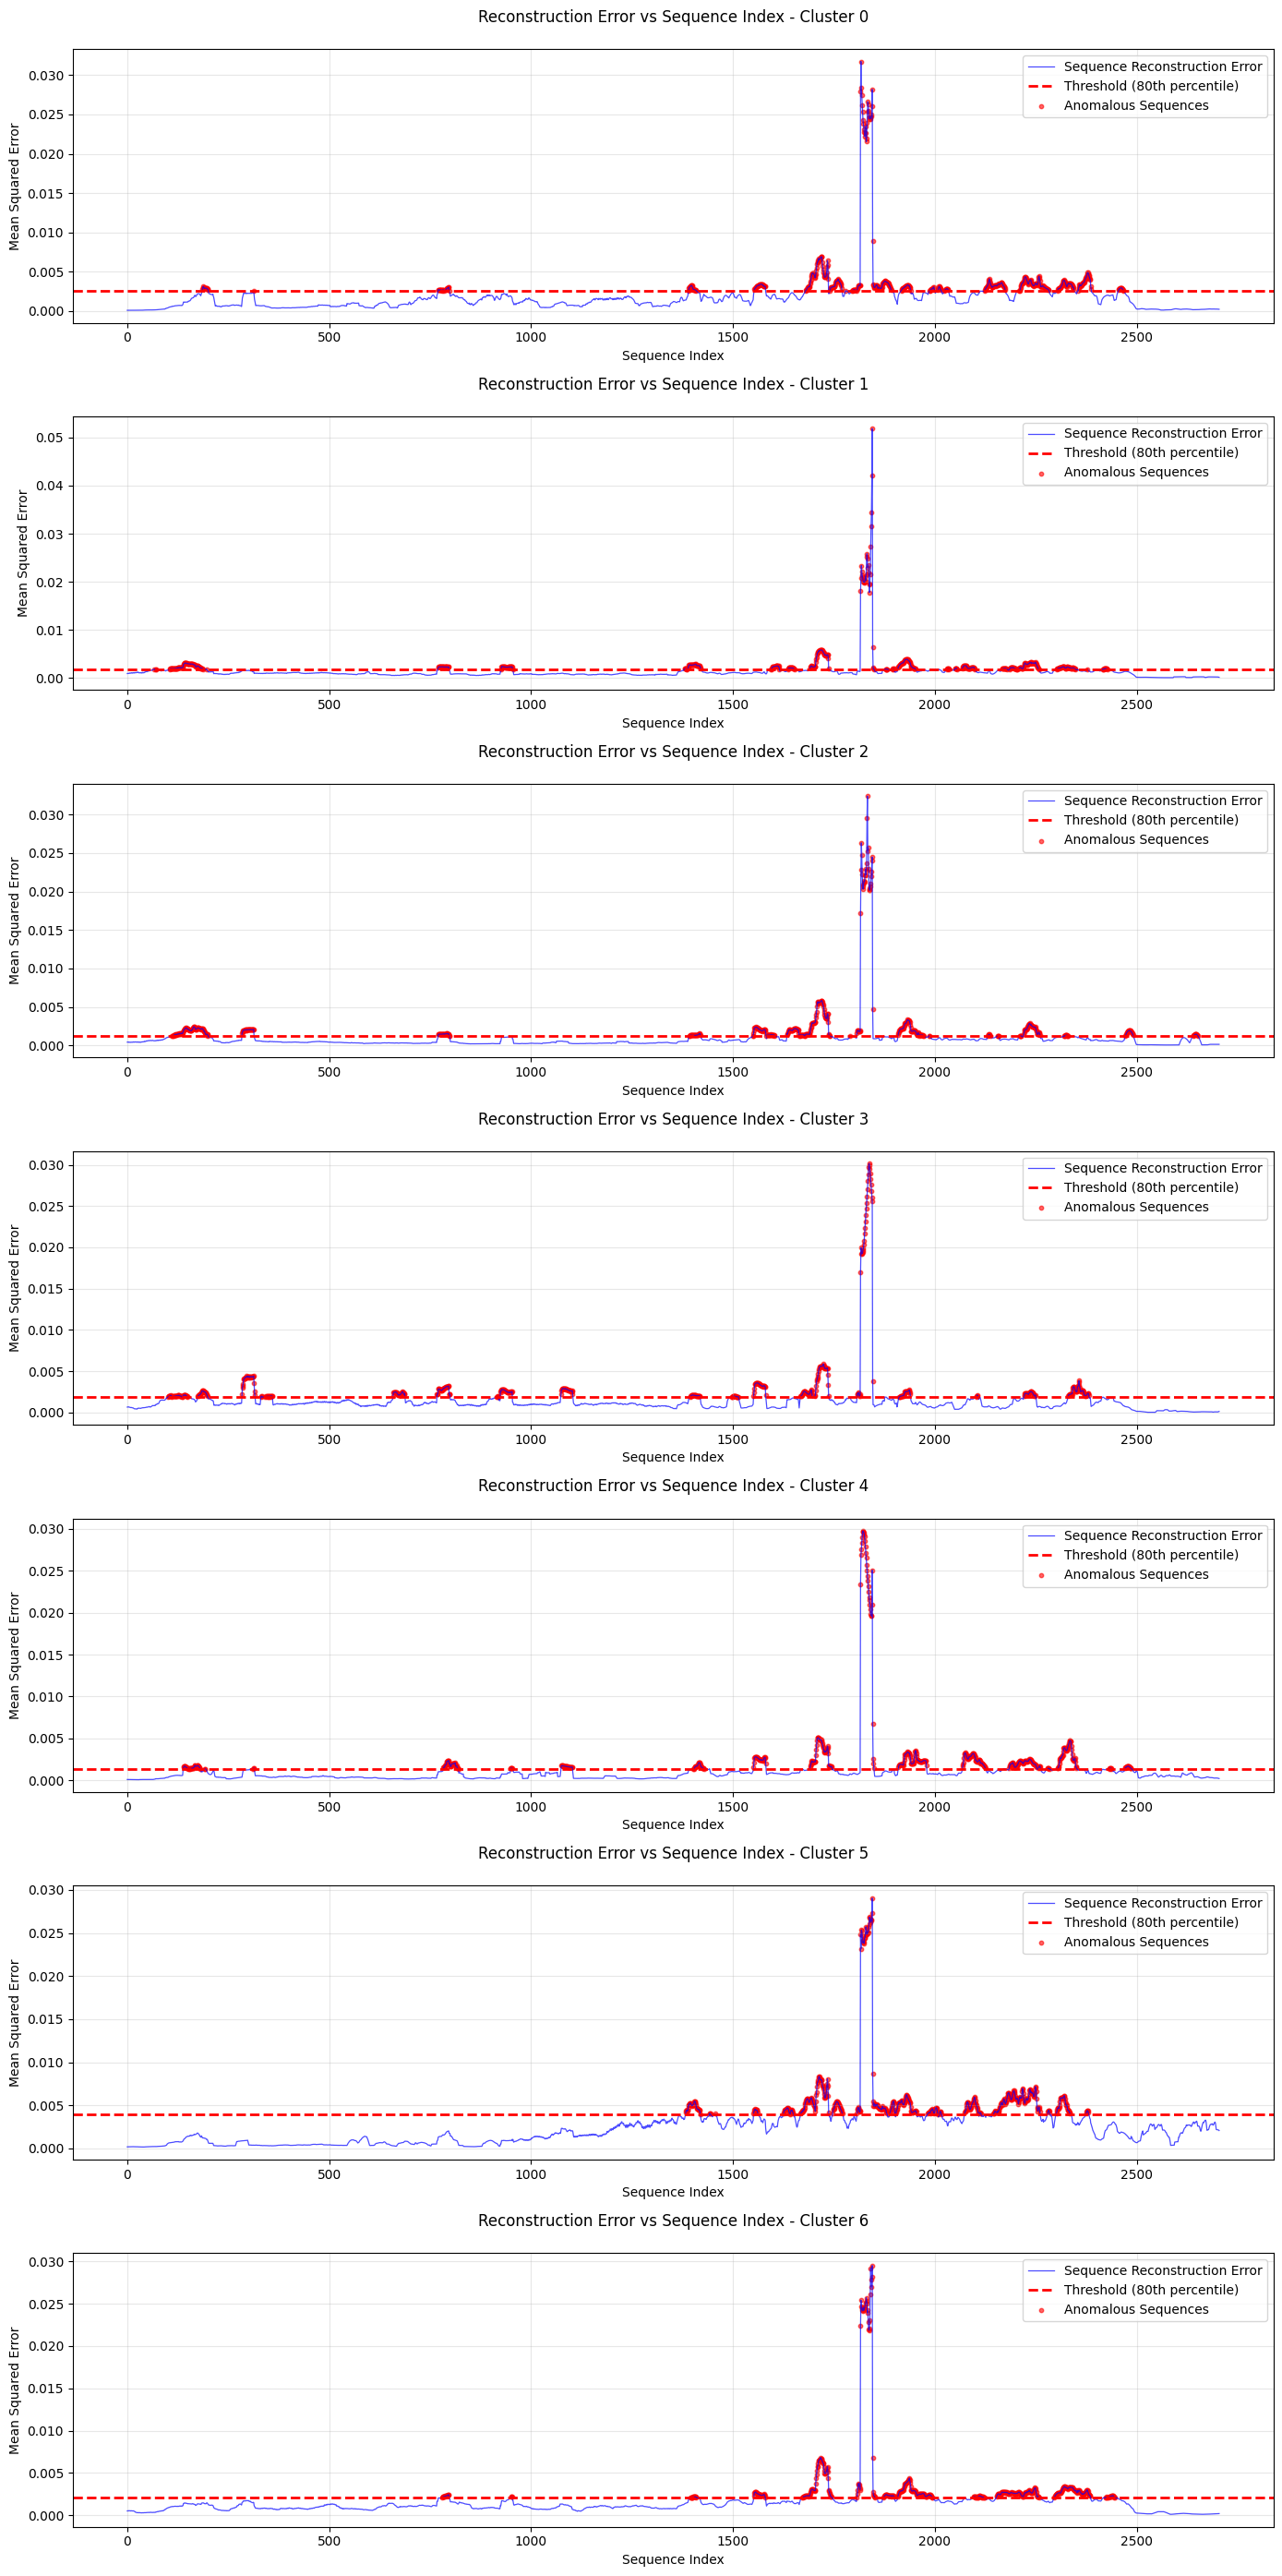

Reconstruction error plots saved to: /home/ranushi/test/Anomaly DetectionMethod/reconstruction_errors_by_cluster.png


<Figure size 640x480 with 0 Axes>

In [38]:
# Visualize reconstruction errors for each cluster
if cluster_models:
    print("\n" + "=" * 70)
    print("RECONSTRUCTION ERROR VISUALIZATION BY CLUSTER")
    print("=" * 70)
    
    # Create plots for each cluster
    n_clusters = len(cluster_models)
    fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 4 * n_clusters))
    
    if n_clusters == 1:
        axes = [axes]
    
    plot_index = 0
    for cluster_id, model_info in cluster_models.items():
        det_results = model_info['detection_results']
        seq_errors = det_results['sequence_errors']
        seq_threshold = det_results['sequence_threshold']
        
        ax = axes[plot_index]
        
        # Plot reconstruction errors
        ax.plot(seq_errors, label='Sequence Reconstruction Error', linewidth=0.9, color='blue', alpha=0.7)
        ax.axhline(seq_threshold, color='red', linestyle='--', linewidth=2,
                  label=f'Threshold ({SEQ_ANOMALY_PCT}th percentile)')
        
        # Highlight anomalous sequences
        anomalous_mask = det_results['sequence_anomaly_mask']
        anomalous_indices = np.where(anomalous_mask)[0]
        ax.scatter(anomalous_indices, seq_errors[anomalous_indices], 
                  color='red', s=10, alpha=0.6, label='Anomalous Sequences')
        
        # Formatting
        ax.set_title(f'Reconstruction Error vs Sequence Index - Cluster {cluster_id}\n')
                    #f'{len(anomalous_indices)} anomalous sequences out of {len(seq_errors)} total')
        ax.set_xlabel('Sequence Index')
        ax.set_ylabel('Mean Squared Error')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text box
        # stats_text = f'Mean Error: {seq_errors.mean():.6f}\n'
        # stats_text += f'Std Error: {seq_errors.std():.6f}\n'
        # stats_text += f'Threshold: {seq_threshold:.6f}'
        # ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            #    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plot_index += 1
    
    plt.tight_layout()
    plt.show()
    
    # Save plot
    plot_file = '/home/ranushi/test/Anomaly DetectionMethod/reconstruction_errors_by_cluster.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Reconstruction error plots saved to: {plot_file}")
    
else:
    print("No cluster models available for visualization")

In [41]:
# Dictionary to store anomalous households with lower consumption
lower_energy_anomalies = {}

for cluster_id, cluster_info in cluster_filtered_data.items():
    cluster_data = cluster_info['data']  # shape: time x households
    cluster_households = cluster_info['households']
    
    if cluster_id not in per_cluster_anomalies:
        continue  # No anomalies detected for this cluster
    
    anomalous_households = per_cluster_anomalies[cluster_id]
    
    # Identify normal households (all households minus anomalous ones)
    normal_households = [hh for hh in cluster_households if hh not in anomalous_households]
    
    if len(normal_households) == 0:
        print(f"Cluster {cluster_id}: No normal households to compare.")
        continue
    
    # Compute mean consumption across time for normal households
    normal_avg = cluster_data[normal_households].mean(axis=1)  # mean over households for each time step
    
    # Check which anomalous households are below normal household average **throughout the entire period**
    low_energy_anomalies = []
    for hh in anomalous_households:
        hh_series = cluster_data[hh]
        if (hh_series < normal_avg).all():  # all time points below normal household mean
            low_energy_anomalies.append(hh)
    
    lower_energy_anomalies[cluster_id] = {
        'anomalous_households': anomalous_households,
        'low_energy_anomalies': low_energy_anomalies,
        'total_anomalies': len(anomalous_households),
        'total_low_energy': len(low_energy_anomalies),
        'percentage_low_energy': len(low_energy_anomalies) / len(anomalous_households) * 100
    }


In [42]:
print("\n=== ANOMALOUS HOUSEHOLDS WITH LOWER ENERGY CONSUMPTION ===")
for cluster_id, info in lower_energy_anomalies.items():
    print(f"\nCluster {cluster_id}:")
    print(f"  Total anomalous households: {info['total_anomalies']}")
    print(f"  Anomalous households with lower energy consumption: {info['total_low_energy']} "
          f"({info['percentage_low_energy']:.1f}%)")
    print(f"  Households: {info['low_energy_anomalies']}")



=== ANOMALOUS HOUSEHOLDS WITH LOWER ENERGY CONSUMPTION ===

Cluster 0:
  Total anomalous households: 20
  Anomalous households with lower energy consumption: 0 (0.0%)
  Households: []

Cluster 1:
  Total anomalous households: 43
  Anomalous households with lower energy consumption: 2 (4.7%)
  Households: ['ID2373', 'ID3427']

Cluster 2:
  Total anomalous households: 35
  Anomalous households with lower energy consumption: 1 (2.9%)
  Households: ['ID3180']

Cluster 3:
  Total anomalous households: 12
  Anomalous households with lower energy consumption: 2 (16.7%)
  Households: ['ID2833', 'ID3201']

Cluster 4:
  Total anomalous households: 12
  Anomalous households with lower energy consumption: 0 (0.0%)
  Households: []

Cluster 5:
  Total anomalous households: 18
  Anomalous households with lower energy consumption: 0 (0.0%)
  Households: []

Cluster 6:
  Total anomalous households: 118
  Anomalous households with lower energy consumption: 1 (0.8%)
  Households: ['ID2808']


In [43]:
# Dictionary to store only high-energy anomalous households
high_energy_anomalies = {}

for cluster_id, info in lower_energy_anomalies.items():
    anomalous_households = info['anomalous_households']
    low_energy_hhs = info['low_energy_anomalies']
    
    # Remove low-energy households from anomalies
    remaining_hhs = [hh for hh in anomalous_households if hh not in low_energy_hhs]
    
    high_energy_anomalies[cluster_id] = remaining_hhs


In [44]:
for cluster_id, hhs in high_energy_anomalies.items():
    if not hhs:
        continue  # Skip if no remaining anomalies
    
    df = pd.DataFrame({
        'household_ID': hhs,
        'cluster': cluster_id,
        'anomaly_type': 'autoencoder_reconstruction_high_energy'
    })
    
    out_csv = f'/home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_{cluster_id}.csv'
    df.to_csv(out_csv, index=False)
    print(f"Cluster {cluster_id} high-energy anomalous households saved to: {out_csv}")


Cluster 0 high-energy anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_0.csv
Cluster 1 high-energy anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_1.csv
Cluster 2 high-energy anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_2.csv
Cluster 3 high-energy anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_3.csv
Cluster 4 high-energy anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_4.csv
Cluster 5 high-energy anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_5.csv
Cluster 6 high-energy anomalous households saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_high_energy_households_cluster_6.csv

In [45]:
print("\n=== HIGH-ENERGY ANOMALOUS HOUSEHOLDS ===")
for cluster_id, hhs in high_energy_anomalies.items():
    print(f"Cluster {cluster_id}: {len(hhs)} high-energy anomalous households")



=== HIGH-ENERGY ANOMALOUS HOUSEHOLDS ===
Cluster 0: 20 high-energy anomalous households
Cluster 1: 41 high-energy anomalous households
Cluster 2: 34 high-energy anomalous households
Cluster 3: 10 high-energy anomalous households
Cluster 4: 12 high-energy anomalous households
Cluster 5: 18 high-energy anomalous households
Cluster 6: 117 high-energy anomalous households


In [46]:
high_energy_anomalies

{np.int64(0): ['ID0183',
  'ID0271',
  'ID0381',
  'ID0558',
  'ID0844',
  'ID0938',
  'ID1009',
  'ID1097',
  'ID1197',
  'ID1985',
  'ID2472',
  'ID2475',
  'ID2486',
  'ID2893',
  'ID2942',
  'ID2952',
  'ID3322',
  'ID3348',
  'ID3358',
  'ID3767'],
 np.int64(1): ['ID0144',
  'ID0310',
  'ID0400',
  'ID0642',
  'ID0759',
  'ID0835',
  'ID1297',
  'ID1309',
  'ID1341',
  'ID1428',
  'ID1485',
  'ID1502',
  'ID1572',
  'ID1582',
  'ID1654',
  'ID1763',
  'ID1800',
  'ID1853',
  'ID1859',
  'ID1898',
  'ID1923',
  'ID1931',
  'ID1977',
  'ID2089',
  'ID2305',
  'ID2345',
  'ID2491',
  'ID2509',
  'ID2603',
  'ID2687',
  'ID2721',
  'ID2769',
  'ID2794',
  'ID2843',
  'ID2872',
  'ID2953',
  'ID3005',
  'ID3138',
  'ID3176',
  'ID3225',
  'ID3642'],
 np.int64(2): ['ID0421',
  'ID0429',
  'ID0490',
  'ID0768',
  'ID1038',
  'ID1088',
  'ID1112',
  'ID1146',
  'ID1215',
  'ID1278',
  'ID1343',
  'ID1510',
  'ID1526',
  'ID1687',
  'ID1862',
  'ID1936',
  'ID1949',
  'ID1968',
  'ID1978',

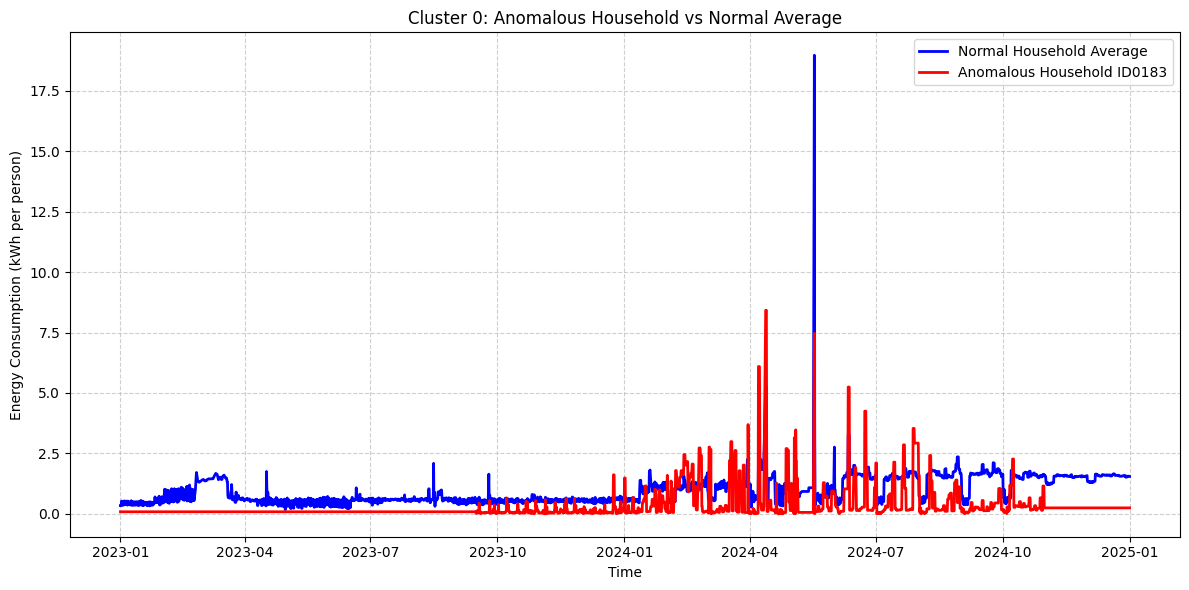

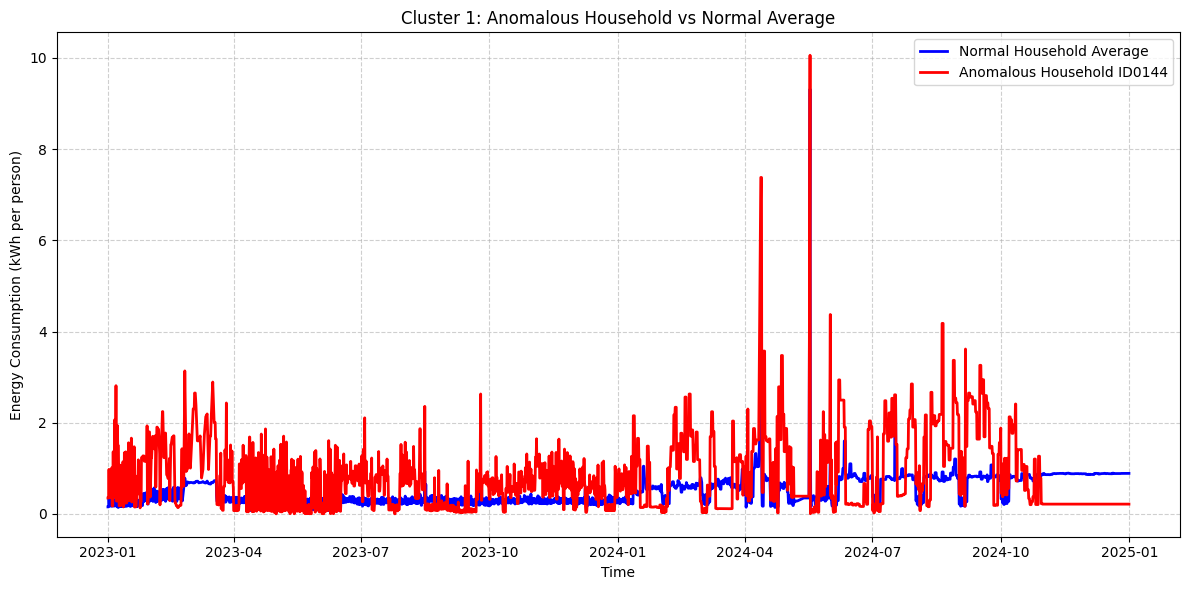

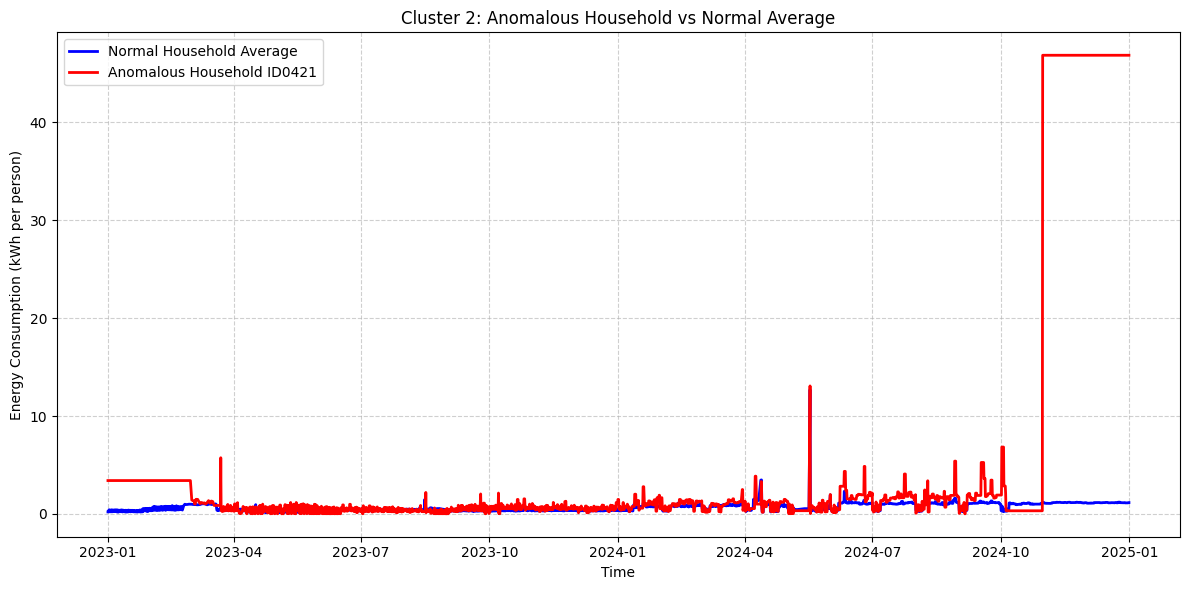

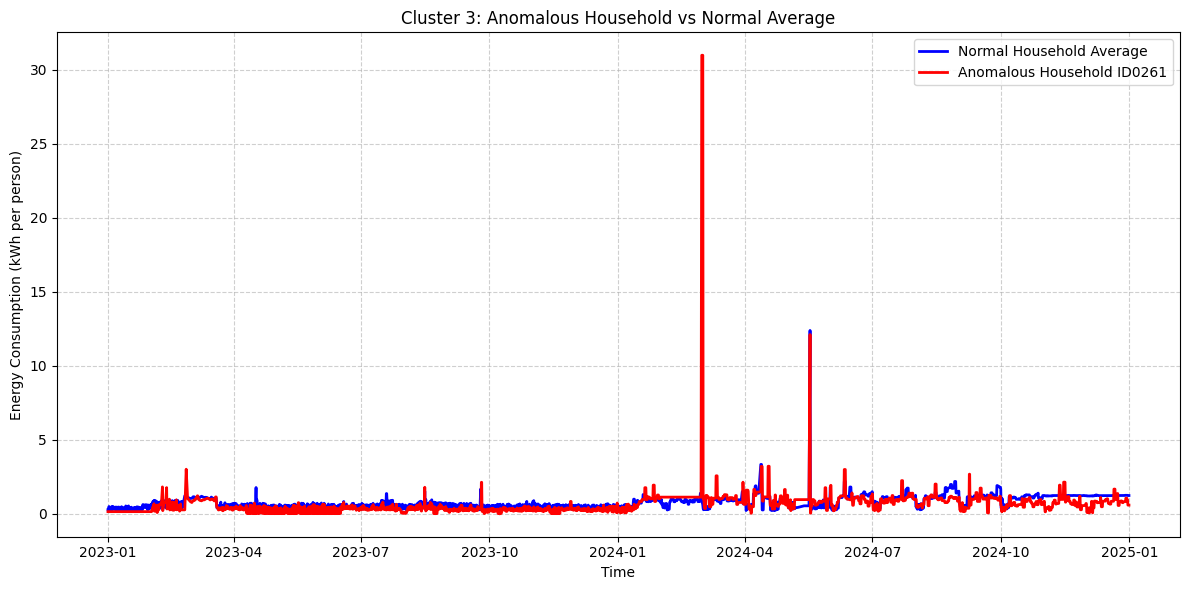

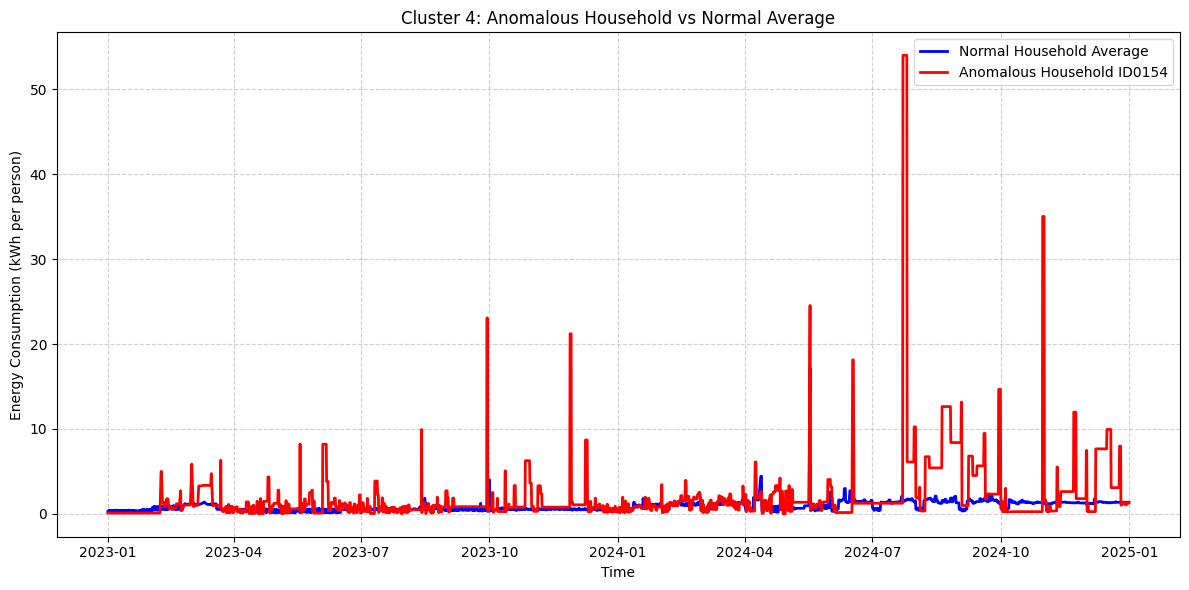

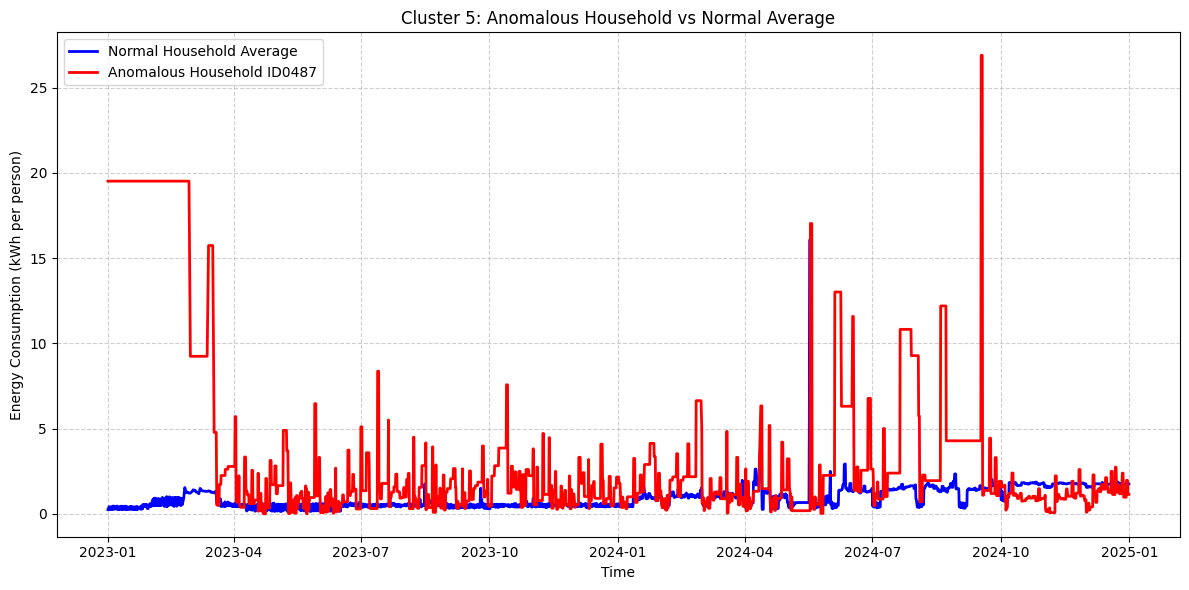

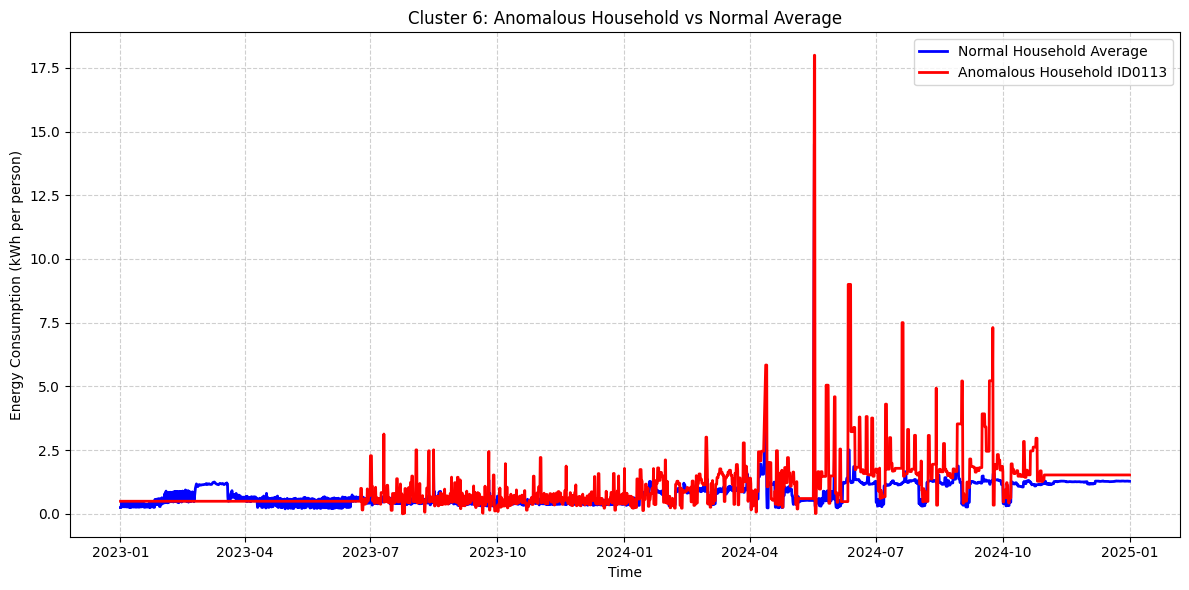

In [47]:
import matplotlib.pyplot as plt

# Pick one anomalous household per cluster and compare against normal average
for cluster_id, cluster_info in cluster_filtered_data.items():
    if cluster_id not in per_cluster_anomalies:
        continue  # Skip clusters with no anomalies
    
    cluster_data = cluster_info['data']  # shape: time x households
    cluster_households = cluster_info['households']
    
    anomalous_households = per_cluster_anomalies[cluster_id]
    normal_households = [hh for hh in cluster_households if hh not in anomalous_households]
    
    if len(normal_households) == 0 or len(anomalous_households) == 0:
        print(f"Cluster {cluster_id}: no comparison possible (all normal or all anomalous).")
        continue
    
    # Compute normal household average (baseline)
    normal_avg = cluster_data[normal_households].mean(axis=1)
    
    # Pick one anomalous household (you can loop through all if you want)
    hh = anomalous_households[0]  
    
    # Get anomalous household series
    hh_series = cluster_data[hh]
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(normal_avg.index, normal_avg.values, label='Normal Household Average', color='blue', linewidth=2)
    plt.plot(hh_series.index, hh_series.values, label=f'Anomalous Household {hh}', color='red', linewidth=2)
    
    plt.title(f"Cluster {cluster_id}: Anomalous Household vs Normal Average")
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh per person)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [48]:
# Dictionary to store max consumption info for validation
max_consumption_info = {}

for cluster_id, cluster_info in cluster_filtered_data.items():
    if cluster_id not in per_cluster_anomalies:
        continue  # Skip clusters with no anomalies

    cluster_data = cluster_info['data']  # time x households
    anomalous_households = per_cluster_anomalies[cluster_id]
    
    if len(anomalous_households) == 0:
        continue

    max_consumption_info[cluster_id] = []

    for hh in anomalous_households:
        hh_series = cluster_data[hh]
        # Find index of maximum consumption
        max_idx = hh_series.idxmax()   # timestamp (datetime)
        max_value = hh_series[max_idx] # value in kWh per person

        max_consumption_info[cluster_id].append({
            'household_ID': hh,
            'max_consumption_kWh_per_person': max_value,
            'datetime': max_idx,
            'date': max_idx.date(),
            'time': max_idx.time()
        })

# Display results
for cluster_id, records in max_consumption_info.items():
    print(f"\nCluster {cluster_id}: Maximum consumption points")
    for r in records:
        print(f"  Household {r['household_ID']}: {r['max_consumption_kWh_per_person']:.2f} kWh per person at {r['datetime']}")



Cluster 0: Maximum consumption points
  Household ID0183: 8.42 kWh per person at 2024-04-12 06:00:00
  Household ID0271: 11.70 kWh per person at 2024-05-17 12:00:00
  Household ID0381: 16.94 kWh per person at 2024-05-17 12:00:00
  Household ID0558: 76.97 kWh per person at 2024-03-01 00:00:00
  Household ID0844: 3632.89 kWh per person at 2024-10-31 00:00:00
  Household ID0938: 31.31 kWh per person at 2024-05-17 12:00:00
  Household ID1009: 65.85 kWh per person at 2024-10-02 00:00:00
  Household ID1097: 29.04 kWh per person at 2024-08-17 00:00:00
  Household ID1197: 19.97 kWh per person at 2024-05-17 12:00:00
  Household ID1985: 30.90 kWh per person at 2023-03-23 00:00:00
  Household ID2472: 7.30 kWh per person at 2024-05-17 12:00:00
  Household ID2475: 5.26 kWh per person at 2024-05-17 12:00:00
  Household ID2486: 55.25 kWh per person at 2024-04-20 18:00:00
  Household ID2893: 1.32 kWh per person at 2024-05-17 18:00:00
  Household ID2942: 25.63 kWh per person at 2024-08-23 00:00:00
  H

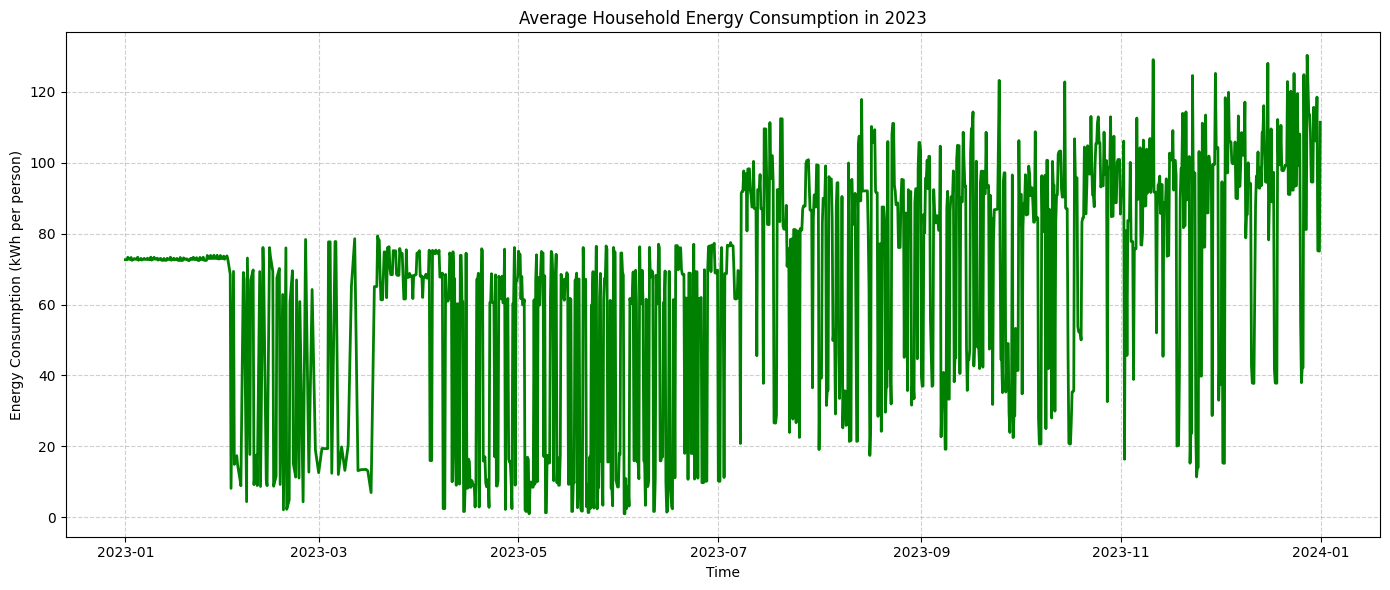

In [51]:
import matplotlib.pyplot as plt

# Make sure pivot_df has datetime index and all households as columns
if not pivot_df.empty:
    # Filter data for the year you want, e.g., 2025
    year = 2023
    yearly_data = pivot_df[pivot_df.index.year == year]

    if yearly_data.empty:
        print(f"No data available for year {year}")
    else:
        # Compute average across all households for each time point
        avg_consumption = yearly_data.mean(axis=1)  # mean over columns (households)
        
        # Plot
        plt.figure(figsize=(14, 6))
        plt.plot(avg_consumption.index, avg_consumption.values, color='green', linewidth=2)
        plt.title(f"Average Household Energy Consumption in {year}")
        plt.xlabel("Time")
        plt.ylabel("Energy Consumption (kWh per person)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
else:
    print("No household data available for plotting")


In [78]:
import pandas as pd

# Prepare a list of rows
rows = []
for cluster_id, households in high_energy_anomalies.items():
    for hh in households:
        rows.append({'household_ID': hh, 'cluster_id': cluster_id})

# Convert to DataFrame
high_energy_df = pd.DataFrame(rows)

# Display the DataFrame
print(high_energy_df.head())


  household_ID  cluster_id
0       ID0183           0
1       ID0271           0
2       ID0381           0
3       ID0558           0
4       ID0844           0


In [76]:
survey_data.columns

Index(['household_ID', 'no_of_electricity_meters',
       'electricity_provider_csc_area', 'own_the_house_or_living_on_rent',
       'occupy_renters_boarders',
       'awareness_of_electricity_consumption_of_renters',
       'built_year_of_the_house', 'type_of_house', 'floor_which_house_located',
       'no_of_storeys', 'floor_area', 'no_of_household_members',
       'charging_method_of_renters_for_electricity',
       'charged_method_for_rent_for_electricity',
       'is_there_business_carried_out_in_the_household', 'type_of_business',
       'whom_or_how_the_house_was_designed',
       'availability_of_certificate_of_compliance',
       'main_material_used_for_walls_of_the_house',
       'main_material_used_for_roof_of_the_house',
       'any_constructions_or_renovations_in_the_household',
       'highest_level_of_education_of_the_chief_wage_earner',
       'occupation_of_the_chief_wage_earner', 'socio_economic_class',
       'total_monthly_expenditure_of_last_month', 'type_of_electr

In [80]:
# Make sure survey_data has household_ID column
if 'household_ID' not in survey_data.columns:
    raise ValueError("survey_data must have 'household_ID' column for merging")

# Select only relevant columns from survey_data
survey_subset = survey_data[['household_ID', 'built_year_of_the_house']].copy()

# Merge with high_energy_df on household_ID
high_energy_df = high_energy_df.merge(survey_subset, on='household_ID', how='left')

# Now recategorize
def recategorize_year(x):
    if pd.isna(x):
        return 'Old / Unknown'
    x = str(x).strip()
    if x.lower() == "don't know" or 'Before 1980' in x or '1980-1989' in x:
        return 'Old / Unknown'
    elif '1990-1999' in x or '2000-2009' in x:
        return 'Middle'
    elif '2010' in x or '2010-2019' in x or '2020' in x:
        return 'Recent'
    else:
        return 'Old / Unknown'

high_energy_df['built_year_cat'] = high_energy_df['built_year_of_the_house'].apply(recategorize_year)

# Optional: fix category order
cat_order = ['Old / Unknown', 'Middle', 'Recent']
high_energy_df['built_year_cat'] = pd.Categorical(
    high_energy_df['built_year_cat'], 
    categories=cat_order, 
    ordered=True
)

print(f"Built year categories distribution:")
print(high_energy_df['built_year_cat'].value_counts())


Built year categories distribution:
built_year_cat
Old / Unknown    106
Middle            94
Recent            52
Name: count, dtype: int64



=== PLOTTING BUILT YEAR DISTRIBUTION BY CLUSTER ===
Count and percentage data:
    cluster_id built_year_cat  count  percentage
0            0  Old / Unknown      7   35.000000
1            0         Middle      8   40.000000
2            0         Recent      5   25.000000
3            1  Old / Unknown     22   55.000000
4            1         Middle      8   20.000000
5            1         Recent     10   25.000000
6            2  Old / Unknown     16   47.058824
7            2         Middle     12   35.294118
8            2         Recent      6   17.647059
9            3  Old / Unknown      7   58.333333
10           3         Middle      5   41.666667
11           3         Recent      0    0.000000
12           4  Old / Unknown      2   18.181818
13           4         Middle      7   63.636364
14           4         Recent      2   18.181818
15           5  Old / Unknown      5   27.777778
16           5         Middle     10   55.555556
17           5         Recent      3  

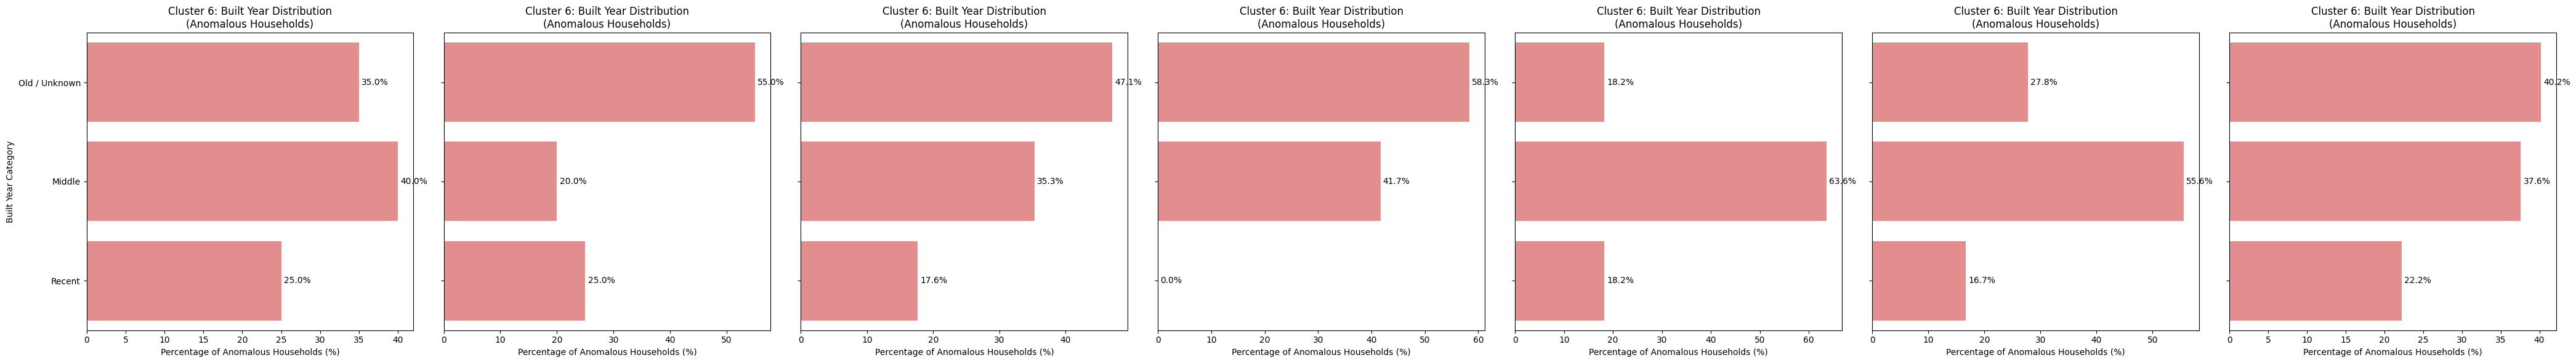


Built year distribution plot saved to: /home/ranushi/test/Anomaly DetectionMethod/anomalous_households_built_year_by_cluster.png


<Figure size 640x480 with 0 Axes>

In [81]:
# Plot built year distribution by cluster for anomalous households
if not high_energy_df.empty and 'built_year_cat' in high_energy_df.columns:
    print("\n=== PLOTTING BUILT YEAR DISTRIBUTION BY CLUSTER ===")
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Count per cluster + built year category
    counts = (
        high_energy_df
        .groupby(['cluster_id', 'built_year_cat'])
        .size()
        .reset_index(name='count')
    )
    
    # Compute percentages within each cluster
    counts['percentage'] = (
        counts.groupby('cluster_id')['count']
        .transform(lambda x: 100 * x / x.sum())
    )
    
    print("Count and percentage data:")
    print(counts)
    
    # Get unique clusters
    clusters = sorted(counts['cluster_id'].unique())
    n_clusters = len(clusters)
    
    # Create horizontal bar plots side by side
    fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 6), sharey=True)
    
    if n_clusters == 1:
        axes = [axes]  # ensure iterable
    
    for ax, cluster in zip(axes, clusters):
        subset = counts[counts['cluster_id'] == cluster]
        
        sns.barplot(
            data=subset,
            x='percentage',
            y='built_year_cat',
            order=cat_order,  # enforce fixed order
            color='lightcoral',
            ax=ax
        )
        
        ax.set_title(f"Cluster {cluster_id}: Built Year Distribution\n(Anomalous Households)")
        ax.set_xlabel("Percentage of Anomalous Households (%)")
        ax.set_ylabel("Built Year Category")
        
        # Add value labels at end of bars
        for container in ax.containers:
            ax.bar_label(container, fmt="%.1f%%", label_type="edge", padding=3)
    
    plt.tight_layout()
    plt.show()
    
    # Save the plot
    plot_file = '/home/ranushi/test/Anomaly DetectionMethod/anomalous_households_built_year_by_cluster.png'
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"\nBuilt year distribution plot saved to: {plot_file}")
    
else:
    print("Cannot create built year distribution plot - data not available")

In [82]:
# Load appliance specifications data
print("=" * 70)
print("LOADING APPLIANCE SPECIFICATIONS DATA FOR AGE ANALYSIS")
print("=" * 70)

# Define path to appliance specifications file
AGE_FILE = Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv')

try:
    # Load appliance specifications data
    spec_df = pd.read_csv(AGE_FILE, low_memory=False)
    print(f"Loaded appliance specifications: {spec_df.shape}")
    
    # Clean column names
    spec_df.columns = [c.strip().lower().replace(' ', '_') for c in spec_df.columns]
    print(f"Columns in spec data: {spec_df.columns.tolist()[:10]}{'...' if len(spec_df.columns) > 10 else ''}")
    
    # Identify key columns
    hh_col_age = next(c for c in spec_df.columns if 'household' in c and 'id' in c)
    appliance_col = next(c for c in spec_df.columns if 'appliance' in c and ('name' in c or c.endswith('appliance')))
    
    print(f"Household ID column: {hh_col_age}")
    print(f"Appliance name column: {appliance_col}")
    
except FileNotFoundError:
    print(f"ERROR: Appliance specifications file not found at {AGE_FILE}")
    spec_df = pd.DataFrame()
except Exception as e:
    print(f"ERROR loading appliance specifications: {e}")
    spec_df = pd.DataFrame()

LOADING APPLIANCE SPECIFICATIONS DATA FOR AGE ANALYSIS
Loaded appliance specifications: (35315, 27)
Columns in spec data: ['id', 'household_id', 'serial_no', 'unique_id', 'noiw1', 'appliance_name', 'no_of_appliances', 'brand1', 'brand2', 'brand3']...
Household ID column: household_id
Appliance name column: appliance_name


In [83]:
# Process appliance age data
if not spec_df.empty:
    print("\n=== PROCESSING APPLIANCE AGE DATA ===")
    
    # Find all purchase_time columns
    age_cols = sorted([c for c in spec_df.columns if c.startswith('purchased_time')],
                      key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
    
    print(f"Found purchase time columns: {age_cols}")
    
    # Function to extract first non-null purchase time
    def pick_age(row):
        for c in age_cols:
            val = str(row[c]).strip()
            if pd.notna(row[c]) and val != '' and val.lower() not in ['nan']:
                return val
        return 'Unknown'
    
    # Extract appliance age
    spec_df['appliance_age'] = spec_df.apply(pick_age, axis=1)
    
    # Create long format dataframe
    age_long = spec_df[[hh_col_age, appliance_col, 'appliance_age']].copy()
    
    print(f"Processed appliance age data shape: {age_long.shape}")
    print(f"Unique appliance ages: {sorted(age_long['appliance_age'].unique())}")
    
    # Define target appliances for analysis
    target_appliances = [
        "Air Conditioner",
        'Refrigerator', 
        'Separate Freezer',
        'Geyser / Hot water systems for bathrooms which operate from electricity',
        'Electric water heater to heat water for drinking purposes',
        'Washing Machine',
        'Electric Water pump',
        'Mobile phone - Smart phones', 
        'Mobile phone - Basic phones',
        'Mobile phone - Feature phones',
        'Hair dryer', 
        'Hair iron / hair curlers', 
        'Electric shavers',
        'Fan', 
        'Electrical exhaust fan fitted above the oven or the hot plate'
    ]
    
    print(f"\nTarget appliances for analysis: {len(target_appliances)}")
    for i, appl in enumerate(target_appliances, 1):
        print(f"{i:2d}. {appl}")
    
else:
    print("No appliance specifications data available for age analysis")
    age_long = pd.DataFrame()
    target_appliances = []


=== PROCESSING APPLIANCE AGE DATA ===
Found purchase time columns: ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']
Processed appliance age data shape: (35315, 3)
Unique appliance ages: ['More than 10 years ago', 'Unknown', 'Within the last 1 year', 'Within the last 1- 5 years', 'Wthin the last 5-10 years']

Target appliances for analysis: 15
 1. Air Conditioner
 2. Refrigerator
 3. Separate Freezer
 4. Geyser / Hot water systems for bathrooms which operate from electricity
 5. Electric water heater to heat water for drinking purposes
 6. Washing Machine
 7. Electric Water pump
 8. Mobile phone - Smart phones
 9. Mobile phone - Basic phones
10. Mobile phone - Feature phones
11. Hair dryer
12. Hair iron / hair curlers
13. Electric shavers
14. Fan
15. Electrical exhaust fan fitted above the oven or the hot plate


In [84]:
# Merge anomalous households with appliance age data
if not age_long.empty and 'combined_anomalies_df' in locals() and not combined_anomalies_df.empty:
    print("\n=== MERGING ANOMALOUS HOUSEHOLDS WITH APPLIANCE AGE DATA ===")
    
    # Filter appliance data to target appliances only
    age_subset = age_long[age_long[appliance_col].isin(target_appliances)].copy()
    print(f"Filtered to target appliances: {age_subset.shape}")
    
    # Check available appliances in the data
    available_target_appliances = set(age_subset[appliance_col].unique()).intersection(set(target_appliances))
    print(f"Available target appliances in data: {len(available_target_appliances)}")
    for appl in sorted(available_target_appliances):
        count = (age_subset[appliance_col] == appl).sum()
        print(f"  {appl}: {count} records")
    
    # Merge with anomalous households data
    age_anomalous = age_subset.merge(
        combined_anomalies_df[['household_ID', 'cluster']], 
        left_on=hh_col_age, 
        right_on='household_ID', 
        how='inner'
    )
    
    print(f"\nMerged anomalous households with appliance age data: {age_anomalous.shape}")
    print(f"Unique anomalous households with appliance data: {age_anomalous['household_ID'].nunique()}")
    print(f"Clusters represented: {sorted(age_anomalous['cluster'].unique())}")
    
    # Check data coverage by cluster
    cluster_coverage = age_anomalous.groupby('cluster')['household_ID'].nunique().reset_index()
    cluster_coverage.columns = ['cluster', 'households_with_appliance_data']
    print(f"\nHouseholds with appliance data by cluster:")
    print(cluster_coverage)
    
else:
    if age_long.empty:
        print("No appliance age data available for merging")
    if 'combined_anomalies_df' not in locals() or combined_anomalies_df.empty:
        print("No anomalous households data available for merging")
    age_anomalous = pd.DataFrame()

No anomalous households data available for merging
